In [1]:
import os
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patch
from scipy.integrate import solve_ivp
import scipy.optimize as sc_opt
import math
from scipy.integrate import quad
import time
from IPython.core.debugger import set_trace
import datetime as dt

from numpy import genfromtxt
import datetime

import sys
sys.path.append('../../models')
from models import firstordermodel, secondordermodel, thirdordermodel

sys.path.append('../')
from tools import stochasticSimulation, derive_regimes, discrete_ivp_solver, \
                    smooth_dap, sol_ivp_wrapper, sol_ivp_wrapper_discrete,\
                    smooth_regime, cost, sigmoid,\
                    simulate_MPC, mergeSwitchCont,\
                    build_initial_ipopt_object,\
                    consMatrix, constraintASparse, plotSwitches, consumption, setupAxis

from model_loader import *
from price_loader import *
from color_loader import *

import matplotlib.patches as mpatches

def plotSwitches(switches,t0,c1,c2,ax):
    n_s = int(len(switches)/2)
    for xc in switches[:n_s]:
        ax.axvline(x=xc+t0,color = c1, alpha = 0.2)
    
    for xc in switches[n_s:]:
        ax.axvline(x=xc+t0,color = c2, alpha = 0.2)

def modification_date(filename):
    t = os.path.getmtime(filename)
    return datetime.datetime.fromtimestamp(t)

from matplotlib import rc

rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)


/Users/madsobdrup/opt/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [2]:
histories_02 = {}
histories_05 = {}
model_systems = ['m1','m2','m3']
n_s = 6
slope = 0.2
#for model_sys in model_systems:
    

model_sys= 'm1'
filename_02 = '../results/sim_history/rk_history_reuse(2018-01-01 12:00:00)_(100_days)' + '_(price_slope_' + str(slope) +  ')_(regime_slope_' + str(slope) +  ')_(seed_1235)_(n_s_' + str(n_s) + ')_(sys_model_' + model_sys + ')_(sys_true_m4).npy'
histories_02[model_sys] = np.load(filename_02,allow_pickle=True).item()
filename_05 = '../results/sim_history/rk_history_reuse(2018-01-01 12:00:00)_(100_days)' + '_(price_slope_' + str(0.5) +  ')_(regime_slope_' + str(0.5) +  ')_(seed_1235)_(n_s_' + str(n_s) + ')_(sys_model_' + model_sys + ')_(sys_true_m4).npy'
histories_05[model_sys] = np.load(filename_05,allow_pickle=True).item()

model_sys = 'm2'
filename_02 = '../results/sim_history/rk_history_reuse(2018-01-01 12:00:00)_(100_days)' + '_(price_slope_' + str(slope) +  ')_(regime_slope_' + str(slope) +  ')_(seed_1235)_(n_s_' + str(n_s) + ')_(sys_model_' + model_sys + ')_(sys_true_m4).npy'
histories_02[model_sys] = np.load(filename_02,allow_pickle=True).item()
filename_05 = '../results/sim_history/rk_history_reuse(2018-01-01 12:00:00)_(100_days)' + '_(price_slope_' + str(0.5) +  ')_(regime_slope_' + str(0.5) +  ')_(seed_1235)_(n_s_' + str(n_s) + ')_(sys_model_' + model_sys + ')_(sys_true_m4).npy'
histories_05[model_sys] = np.load(filename_05,allow_pickle=True).item()

model_sys = 'm3'
filename_02 = '../results/sim_history/rk_history_reuse(2018-01-01 12:00:00)_(100_days)' + '_(price_slope_' + str(slope) +  ')_(regime_slope_' + str(slope) +  ')_(seed_1235)_(n_s_' + str(n_s) + ')_(sys_model_' + model_sys + ')_(sys_true_m4).npy'
histories_02[model_sys] = np.load(filename_02,allow_pickle=True).item()
filename_05 = '../results/sim_history/rk_history_reuse(2018-01-01 12:00:00)_(100_days)' + '_(price_slope_' + str(0.5) +  ')_(regime_slope_' + str(0.5) +  ')_(seed_1235)_(n_s_' + str(n_s) + ')_(sys_model_' + model_sys + ')_(sys_true_m4).npy'
histories_05[model_sys] = np.load(filename_05,allow_pickle=True).item()


In [3]:
# Load corresponding Spot models
histories_02_dap = {}
histories_05_dap = {}
model_systems = ['m1','m2','m3']
n_s = 6
for model_sys in model_systems:
    filename_02 = '../results/sim_history/og_history_reuse(2018-01-01 12:00:00)_(100_days)' + '_(price_slope_' + str(0.2) +  ')_(regime_slope_' + str(0.2) +  ')_(seed_1235)_(n_s_' + str(n_s) + ')_(sys_model_' + model_sys + ')_(sys_true_m4).npy'
    histories_02_dap[model_sys] = np.load(filename_02,allow_pickle=True).item()
    filename_05 = '../results/sim_history/og_history_reuse(2018-01-01 12:00:00)_(100_days)' + '_(price_slope_' + str(0.5) +  ')_(regime_slope_' + str(0.5) +  ')_(seed_1235)_(n_s_' + str(n_s) + ')_(sys_model_' + model_sys + ')_(sys_true_m4).npy'
    histories_05_dap[model_sys] = np.load(filename_05,allow_pickle=True).item()


#mod_times.append(modification_date(filename))
    

In [4]:
filename_02 = '../results/sim_history/rk_history_reuse(2018-01-01 12:00:00)_(100_days)' + '_(price_slope_' + str(0.2) +  ')_(regime_slope_' + str(0.2) +  ')_(seed_1235)_(n_s_' + str(n_s) + ')_(sys_model_' + model_sys + ')_(sys_true_m4).npy'
histories_02_reuse = np.load(filename_02,allow_pickle=True).item()


## Objective functions

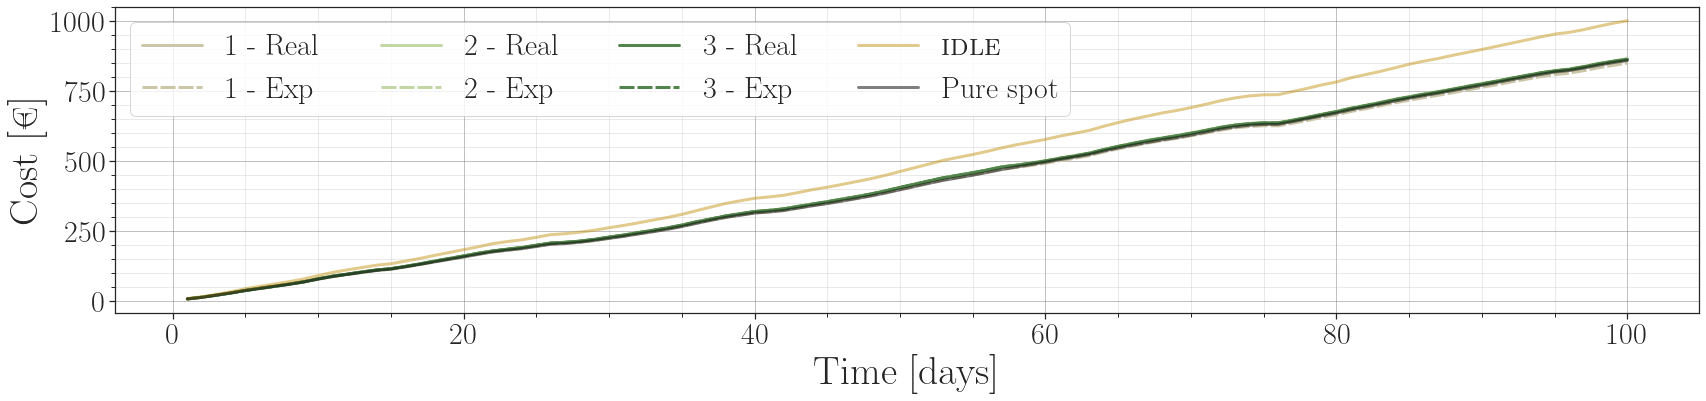

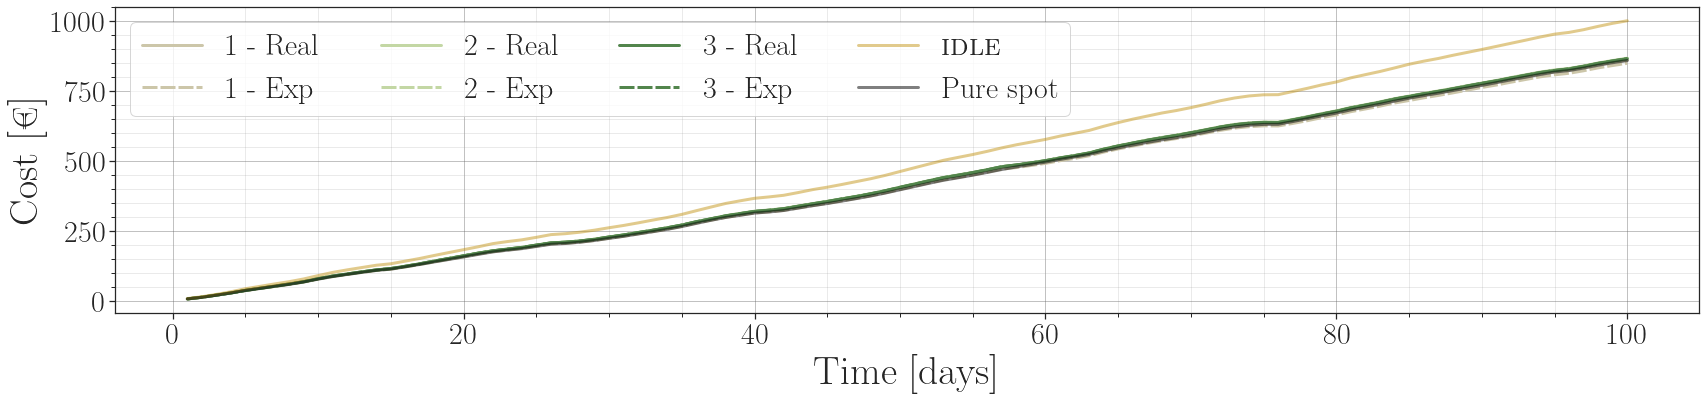

In [6]:
linewidth = 3

price_m1_02 = np.array([histories_02['m1']['price_true'][day][-1] for day in range(100)])
price_m2_02 = np.array([histories_02['m2']['price_true'][day][-1] for day in range(100)])
price_m3_02 = np.array([histories_02['m3']['price_true'][day][-1] for day in range(100)])
price_m1_05 = np.array([histories_05['m1']['price_true'][day][-1] for day in range(100)])
price_m2_05 = np.array([histories_05['m2']['price_true'][day][-1] for day in range(100)])
price_m3_05 = np.array([histories_05['m3']['price_true'][day][-1] for day in range(100)])

price_m1_02_exp = np.array([histories_02['m1']['price_model_rk'][day][-1] for day in range(100)])
price_m2_02_exp = np.array([histories_02['m2']['price_model_rk'][day][-1] for day in range(100)])
price_m3_02_exp = np.array([histories_02['m3']['price_model_rk'][day][-1] for day in range(100)])
price_m1_05_exp = np.array([histories_05['m1']['price_model_rk'][day][-1] for day in range(100)])
price_m2_05_exp = np.array([histories_05['m2']['price_model_rk'][day][-1] for day in range(100)])
price_m3_05_exp = np.array([histories_05['m3']['price_model_rk'][day][-1] for day in range(100)])

price_m1_og = np.array([histories_02_dap['m1']['price_true'][day][-1] for day in range(100)])
price_m1_og_05 = np.array([histories_05_dap['m1']['price_true'][day][-1] for day in range(100)])

price_idle = np.array([histories_02_reuse['price_true_idle'][day][-1] for day in range(100)])
# Use reuse since this does not have diffusion = Expected
price_idle_exp = np.array([histories_02_reuse['price_true_idle'][day][-1] for day in range(100)])

price_init = np.array([histories_02['m1']['price_true_init_switch'][day][-1] for day in range(100)])

fig = plt.figure(figsize=(25,5))  
days = np.arange(1,101)
ax = fig.add_subplot(111)
ax.plot(days,price_m1_02,label= r'$\textnormal{1 - Real}$',color=col_mod1_line,linewidth=linewidth)
ax.plot(days,price_m1_02_exp,label= r'$\textnormal{1 - Exp}$',color=col_mod1_line,linestyle=exp_line_style,linewidth=linewidth)

ax.plot(days,price_m2_02,label= r'$\textnormal{2 - Real}$',color=col_mod2,linewidth=linewidth)
ax.plot(days,price_m2_02_exp,label= r'$\textnormal{2 - Exp}$',color=col_mod2,linestyle=exp_line_style,linewidth=linewidth)

ax.plot(days,price_m3_02,label= r'$\textnormal{3 - Real}$',color=col_mod3,linewidth=linewidth)
ax.plot(days,price_m3_02_exp,label= r'$\textnormal{3 - Exp}$',color=col_mod3,linestyle=exp_line_style,linewidth=linewidth)

ax.plot(days,price_idle,label= r'$\textnormal{\textsc{idle}}$',color=col_idle,alpha = 0.5,linewidth=linewidth)

ax.plot(days,price_m1_og,label= r'$\textnormal{Pure spot}$',color='black',alpha = 0.5,linewidth=linewidth)

setupAxis(ax,ncol_legend=4)

ax.set_ylabel(r'$\textnormal{Cost [€]} $')
ax.set_xlabel(r'$\textnormal{Time [days]} $')

plt.subplots_adjust(hspace = 0.,bottom=0.1, top =0.95,left = 0.07, right = 0.95,)
plt.savefig(FIGS + '/simulation/rk_longterm_cost_accu_02_no_diff.pdf',format='pdf')


fig = plt.figure(figsize=(25,5))  
ax = fig.add_subplot(111)
ax.plot(days,price_m1_05,label= r'$\textnormal{1 - Real}$',color=col_mod1_line,linewidth=linewidth)
ax.plot(days,price_m1_05_exp,label= r'$\textnormal{1 - Exp}$',color=col_mod1_line,linestyle=exp_line_style,linewidth=linewidth)

ax.plot(days,price_m2_05,label= r'$\textnormal{2 - Real}$',color=col_mod2,linewidth=linewidth)
ax.plot(days,price_m2_05_exp,label= r'$\textnormal{2 - Exp}$',color=col_mod2,linestyle=exp_line_style,linewidth=linewidth)

ax.plot(days,price_m3_05,label= r'$\textnormal{3 - Real}$',color=col_mod3,linewidth=linewidth)
ax.plot(days,price_m3_05_exp,label= r'$\textnormal{3 - Exp}$',color=col_mod3,linestyle=exp_line_style,linewidth=linewidth)

ax.plot(days,price_idle,label= r'$\textnormal{\textsc{idle}}$',color=col_idle,alpha = 0.5,linewidth=linewidth)

ax.plot(days,price_m1_og_05,label= r'$\textnormal{Pure spot}$',color='black',alpha = 0.5,linewidth=linewidth)

#ax.plot(rel_dap_m1,label= r'$\textnormal{Model 1 - Dap}$',color='black')
#ax.plot(rel_dap_m1_exp,label= r'$\textnormal{Model 1 - Dap}$',color='black',alpha = 0.5)
setupAxis(ax,ncol_legend=4)

ax.set_ylabel(r'$\textnormal{Cost [€]} $')
ax.set_xlabel(r'$\textnormal{Time [days]} $')


plt.subplots_adjust(hspace = 0.,bottom=0.1, top =0.95,left = 0.07, right = 0.95,)
plt.savefig(FIGS + '/simulation/rk_longterm_cost_accu_05_no_diff.pdf',format='pdf')



# Cost pr time in IDLE

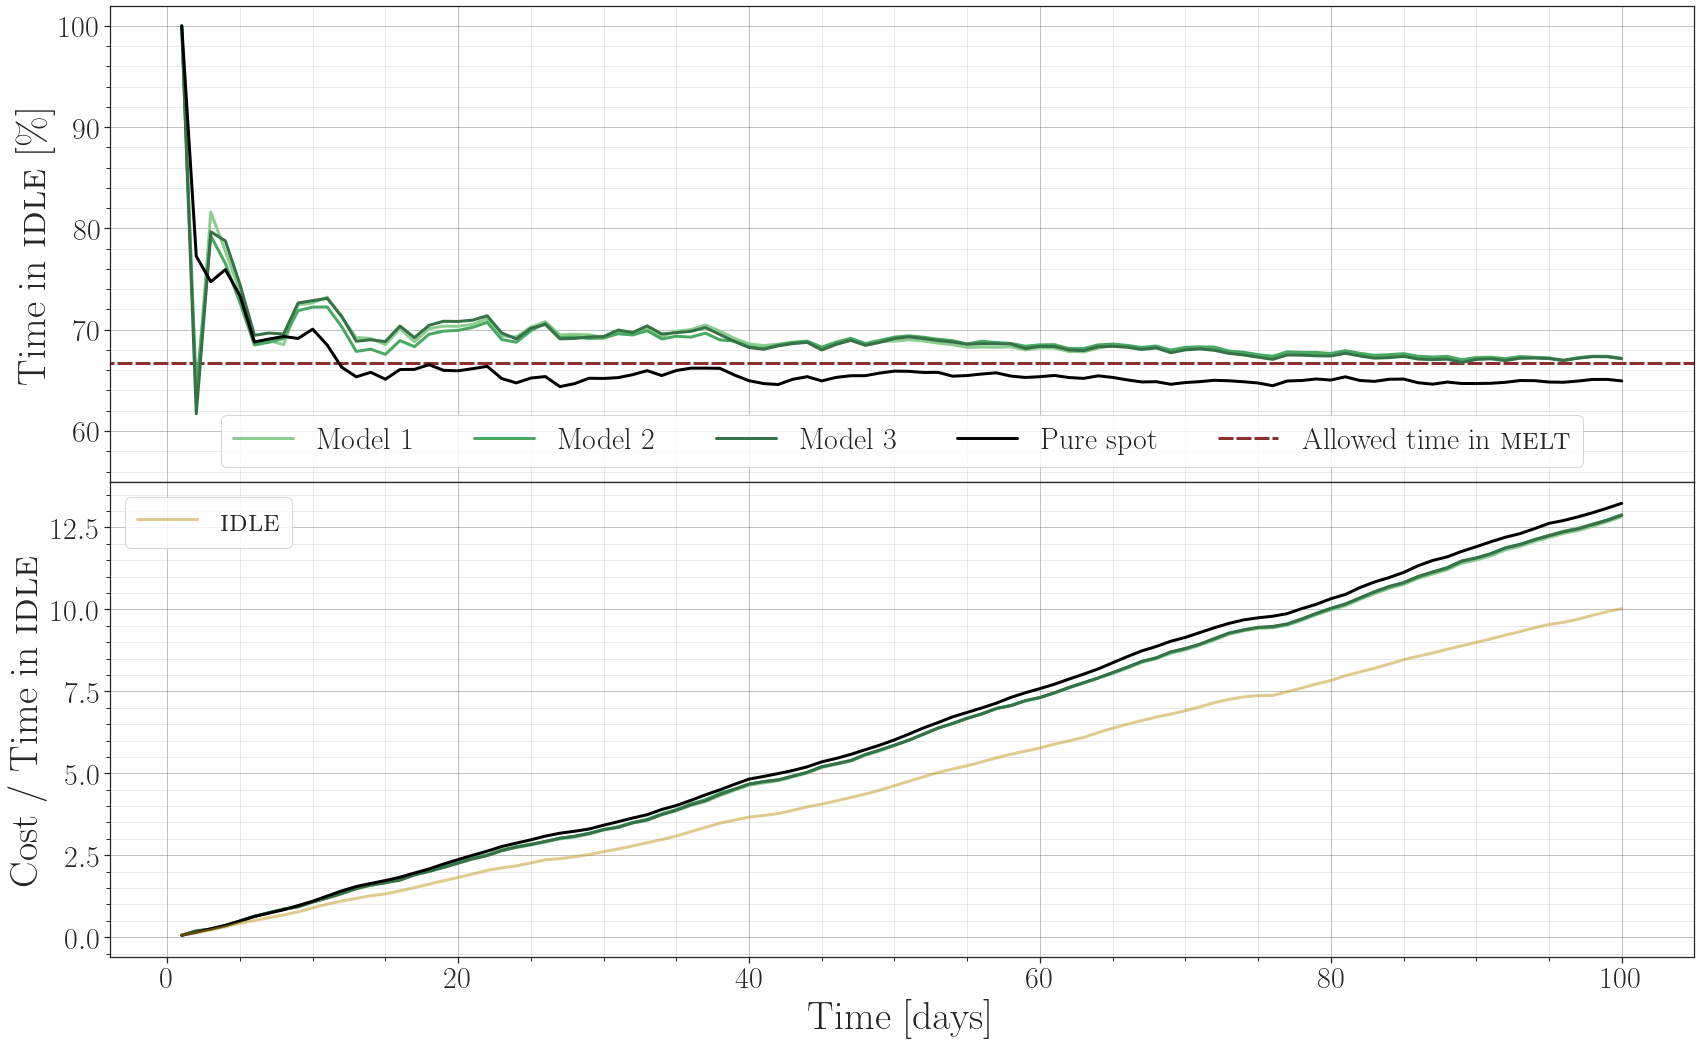

In [7]:
days_to_plot=np.arange(0,100)

percent_in_idle_rk = {}
T_plot_rk = {}
for model in ['m1', 'm2', 'm3']:
    
    T_plot_og_dap = np.concatenate([histories_02_dap['m1']['T'][0] + day * 60*24 for day in days_to_plot])
    T_plot = np.concatenate([histories_02[model]['T'][0] + day * 60*24 for day in days_to_plot])

    dt_rk = (T_plot[2] - T_plot[1])
    dt_og = (T_plot_og_dap[2] - T_plot_og_dap[1])

    last_time_in_idle_day_rk = 0.
    time_idle_rk = np.array([])

    last_time_in_idle_day_og = 0.
    time_idle_og = np.array([])


    for day in days_to_plot:
        T_day_rk = T_plot[(day*24*60 <= T_plot) & (T_plot<(day+1)*24*60)]
        regime_rk = np.round((1-smooth_regime(T_day_rk,histories_02[model]['SWITCHES_rk'][day] + day*24*60,slope=20000)))
        time_in_idle_day_rk = np.cumsum(regime_rk) * dt_rk + last_time_in_idle_day_rk# - T_day_rk[0]
        last_time_in_idle_day_rk = time_in_idle_day_rk[-1] # Update and append to the time in idle vector
        time_idle_rk = np.append(time_idle_rk, time_in_idle_day_rk)

        T_day_og = T_plot_og_dap[(day*24*60 <= T_plot_og_dap) & (T_plot_og_dap<(day+1)*24*60)]
        regime_og = np.round((1-smooth_regime(T_day_og,histories_02_dap[model]['SWITCHES_dap'][day] + day*24*60,slope=20000)))
        time_in_idle_day_og = np.cumsum(regime_og) * dt_og + last_time_in_idle_day_og# - T_day_og[0]
        last_time_in_idle_day_og = time_in_idle_day_og[-1]
        time_idle_og = np.append(time_idle_og, time_in_idle_day_og)

    percent_in_idle_rk[model] = time_idle_rk/(T_plot - T_plot[0] + dt_rk) * 100
    percent_in_idle_og = time_idle_og/(T_plot_og_dap - T_plot_og_dap[0] + dt_og) * 100
    
    T_plot_rk[model] = T_plot


fig = plt.figure(figsize=(25,15))  

ax2 = fig.add_subplot(211)

ax2.plot(days,percent_in_idle_rk['m1'][::7200],color = greens[5],linewidth=linewidth,label=r'$\textnormal{Model 1}$')
ax2.plot(days,percent_in_idle_rk['m2'][::7200],color = greens[3],linewidth=linewidth,label=r'$\textnormal{Model 2}$')
ax2.plot(days,percent_in_idle_rk['m3'][::7200],color = greens[1],linewidth=linewidth,label=r'$\textnormal{Model 3}$')
ax2.plot(days,percent_in_idle_og[::720],color = 'black',linewidth=linewidth,label=r'$\textnormal{Pure spot}$')
xlim = ax2.get_xlim()
ax2.hlines(100*(1-8/24),-100,210,linestyle=exp_line_style,color = red[1],linewidth=linewidth,label=r'$\textnormal{Allowed time in \textsc{melt}}$')

setupAxis(ax2,ncol_legend=6)
ax2.legend(ncol=5,loc='lower center',prop={'size': 30})

ax2.set_xlabel(r'$\textnormal{Cost [€]} $')
ax2.set_ylabel(r'$\textnormal{Time in \textsc{idle} [\%]} $')

ax2.set_xlim(xlim)
ax2.set_ylim(ymin = 55)


ax1 = fig.add_subplot(212)

ax1.plot(days,price_m1_02/percent_in_idle_rk['m1'][::7200],color = greens[5],linewidth=linewidth,label=r'')
ax1.plot(days,price_m2_02/percent_in_idle_rk['m2'][::7200],color = greens[3],linewidth=linewidth,label=r'')
ax1.plot(days,price_m3_02/percent_in_idle_rk['m3'][::7200],color = greens[1],linewidth=linewidth,label=r'')
ax1.plot(days,price_m1_og/percent_in_idle_og[::720],color = 'black',linewidth=linewidth,label=r'')

ax1.plot(days,price_idle/100,color=col_idle,alpha = 0.5,linewidth=linewidth,label=r'$\textnormal{\textsc{idle}}$')
price_idle
setupAxis(ax1,ncol_legend=4,nolegend=False)

ax1.set_ylabel(r'$\textnormal{Cost / Time in \textsc{idle}} $')
ax1.set_xlabel(r'$\textnormal{Time [days]}$')



plt.subplots_adjust(hspace = 0.,bottom=0.07, top =0.95,left = 0.07, right = 0.95,)
plt.savefig(FIGS + '/simulation/rk_longterm_cost_per_time_no_diff.pdf',format='pdf')


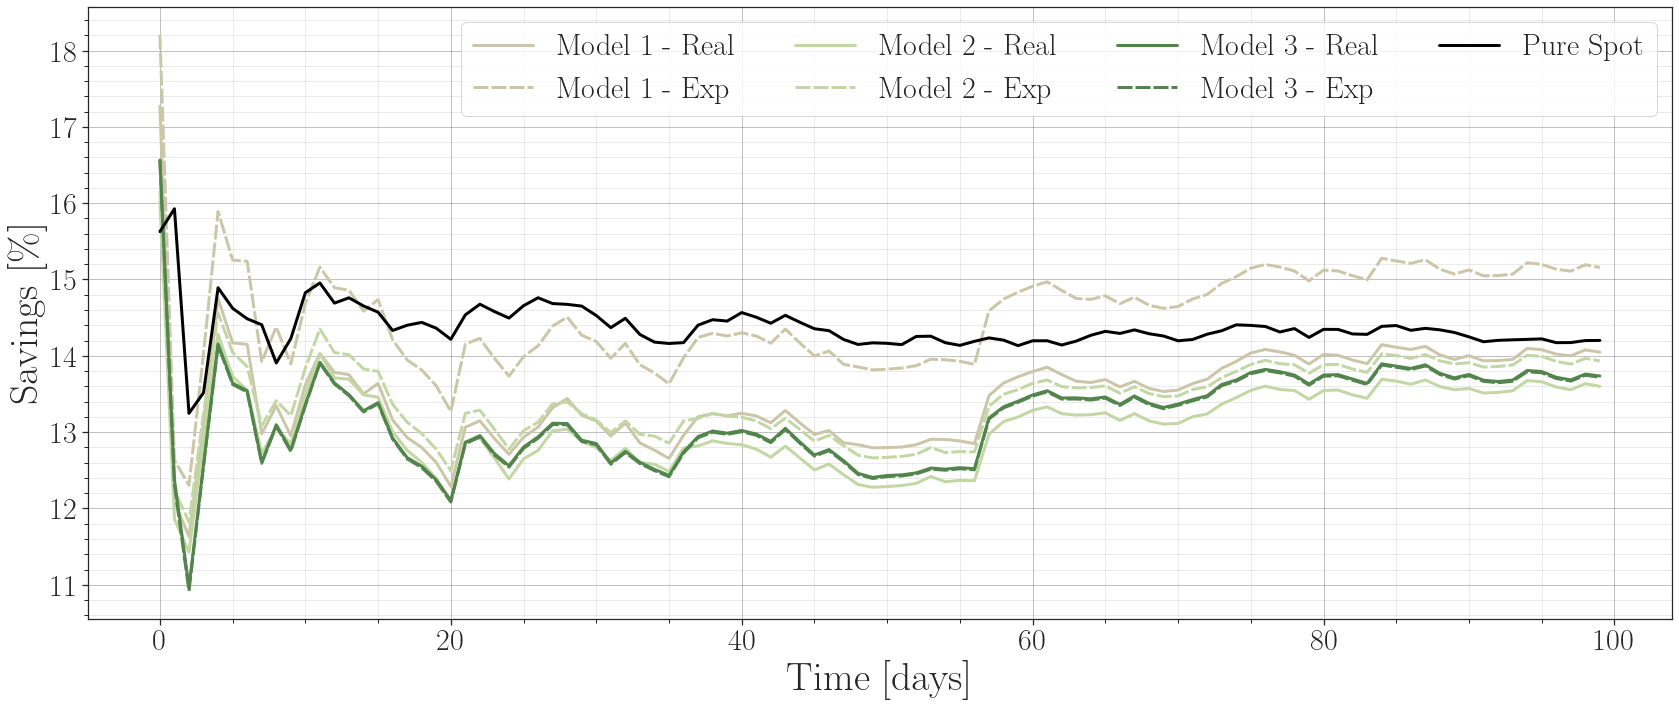

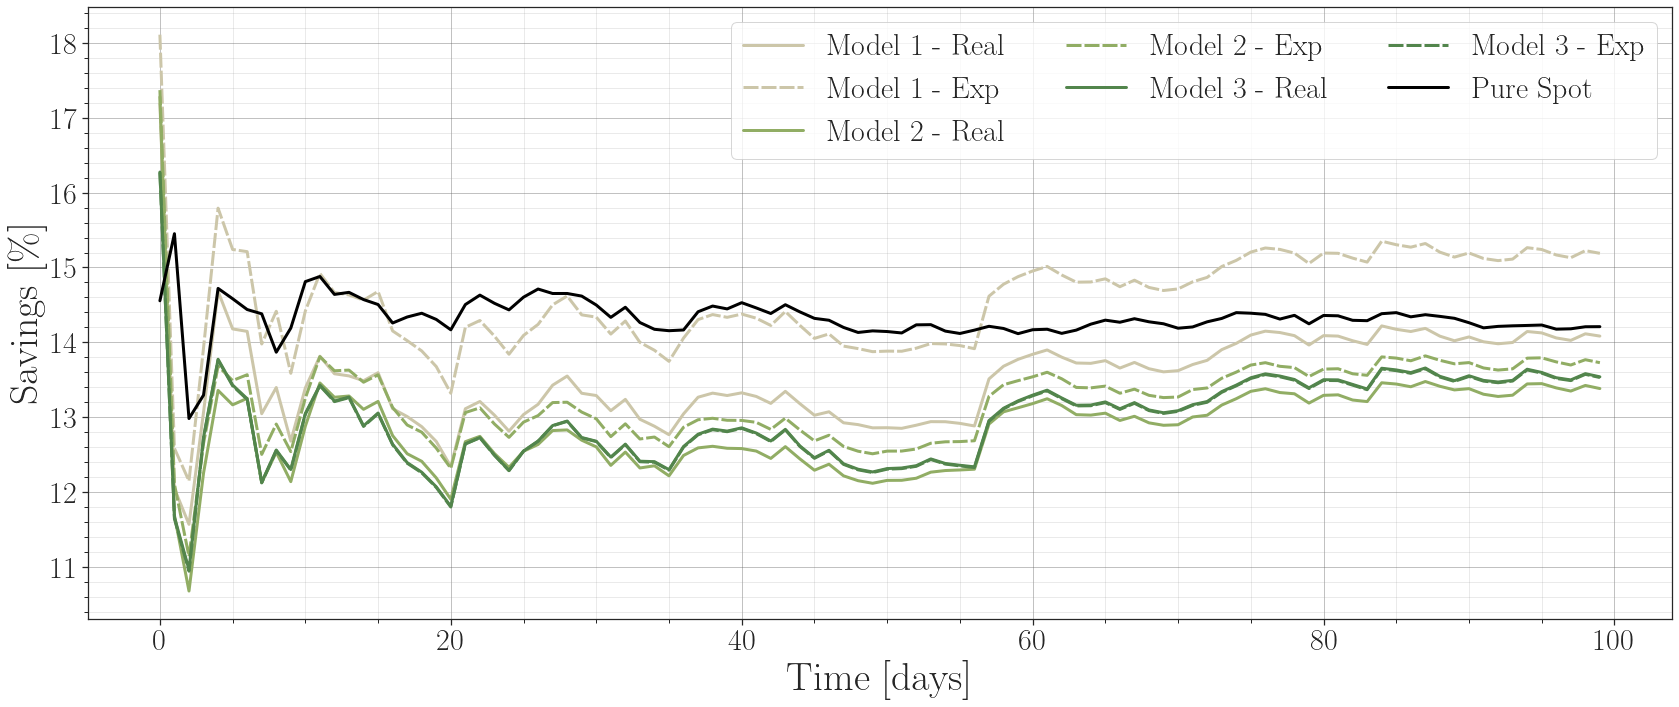

In [115]:
linewidth = 3

price_m1_02_save = (price_idle - price_m1_02)/price_idle
price_m2_02_save = (price_idle - price_m2_02)/price_idle
price_m3_02_save = (price_idle - price_m3_02)/price_idle
price_m1_05_save = (price_idle - price_m1_05)/price_idle
price_m2_05_save = (price_idle - price_m2_05)/price_idle
price_m3_05_save = (price_idle - price_m3_05)/price_idle

price_m1_og_save = (price_idle - price_m1_og)/price_idle
price_m1_og_05_save = (price_idle - price_m1_og_05)/price_idle

price_init_save = (price_idle - price_init)/price_idle

price_m1_02_save_exp = (price_idle_exp - price_m1_02_exp)/price_idle_exp
price_m2_02_save_exp = (price_idle_exp - price_m2_02_exp)/price_idle_exp
price_m3_02_save_exp = (price_idle_exp - price_m3_02_exp)/price_idle_exp
price_m1_05_save_exp = (price_idle_exp - price_m1_05_exp)/price_idle_exp
price_m2_05_save_exp = (price_idle_exp - price_m2_05_exp)/price_idle_exp
price_m3_05_save_exp = (price_idle_exp - price_m3_05_exp)/price_idle_exp



#price_idle = [histories_05['m3']['price_true_idle'][day][-1] for day in range(100)]


fig = plt.figure(figsize=(25,10))  
ax = fig.add_subplot(111)
ax.plot(price_m1_02_save,label= r'$\textnormal{Model 1 - Real}$',color=col_mod1_line,linewidth=linewidth)
ax.plot(price_m1_02_save_exp,label= r'$\textnormal{Model 1 - Exp}$',color=col_mod1_line,linestyle=exp_line_style,linewidth=linewidth)

ax.plot(price_m2_02_save,label= r'$\textnormal{Model 2 - Real}$',color=col_mod2,linewidth=linewidth)
ax.plot(price_m2_02_save_exp,label= r'$\textnormal{Model 2 - Exp}$',color=col_mod2,linestyle=exp_line_style,linewidth=linewidth)

ax.plot(price_m3_02_save,label= r'$\textnormal{Model 3 - Real}$',color=col_mod3,linewidth=linewidth)
ax.plot(price_m3_02_save_exp,label= r'$\textnormal{Model 3 - Exp}$',color=col_mod3,linestyle=exp_line_style,linewidth=linewidth)

ax.plot(price_m1_og_save,label= r'$\textnormal{Pure Spot}$',color='black',linewidth=linewidth)
#ax.plot(price_idle,label= r'$\textsc{idle}$',color=col_idle,alpha = 0.5,linewidth=linewidth)

#ax.plot(rel_dap_m1,label= r'$\textnormal{Model 1 - Dap}$',color='black')
#ax.plot(rel_dap_m1_exp,label= r'$\textnormal{Model 1 - Dap}$',color='black',alpha = 0.5)
setupAxis(ax,ncol_legend=4)

y_ticks = ax.get_yticks()
[str(int(100*y_ticks[i])) for i in range(len(y_ticks))]
ax.set_yticklabels(['$'+ str(int(100*y_ticks[i]))+'$' for i in range(len(y_ticks))])

ax.set_ylabel(r'$\textnormal{Savings [\%]} $')
ax.set_xlabel(r'$\textnormal{Time [days]} $')

plt.subplots_adjust(hspace = 0.,bottom=0.1, top =0.95,left = 0.07, right = 0.95,)
plt.savefig(FIGS + '/simulation/rk_longterm_save_accu_02_no_diff.pdf',format='pdf')


fig = plt.figure(figsize=(25,10))  
ax = fig.add_subplot(111)
ax.plot(price_m1_05_save,label= r'$\textnormal{Model 1 - Real}$',color=col_mod1_line,linewidth=linewidth)
ax.plot(price_m1_05_save_exp,label= r'$\textnormal{Model 1 - Exp}$',color=col_mod1_line,linestyle=(0, (5, 1)),linewidth=linewidth)

ax.plot(price_m2_05_save,label= r'$\textnormal{Model 2 - Real}$',color=col_mod2_line,linewidth=linewidth)
ax.plot(price_m2_05_save_exp,label= r'$\textnormal{Model 2 - Exp}$',color=col_mod2_line,linestyle=(0, (5, 1)),linewidth=linewidth)

ax.plot(price_m3_05_save,label= r'$\textnormal{Model 3 - Real}$',color=col_mod3,linewidth=linewidth)
ax.plot(price_m3_05_save_exp,label= r'$\textnormal{Model 3 - Exp}$',linestyle=(0, (5, 1)),color=col_mod3,linewidth=linewidth)

ax.plot(price_m1_og_05_save,label= r'$\textnormal{Pure Spot}$',color='black',linewidth=linewidth)
#ax.plot(price_idle,label= r'$\textsc{idle}$',color=col_idle,alpha = 0.5,linewidth=linewidth)

#ax.plot(rel_dap_m1,label= r'$\textnormal{Model 1 - Dap}$',color='black')
#ax.plot(rel_dap_m1_exp,label= r'$\textnormal{Model 1 - Dap}$',color='black',alpha = 0.5)
setupAxis(ax,ncol_legend=3)

y_ticks = ax.get_yticks()
[str(int(100*y_ticks[i])) for i in range(len(y_ticks))]
ax.set_yticklabels(['$'+ str(int(100*y_ticks[i]))+'$' for i in range(len(y_ticks))])

ax.set_ylabel(r'$\textnormal{Savings [\%]} $')
ax.set_xlabel(r'$\textnormal{Time [days]} $')

plt.subplots_adjust(hspace = 0.,bottom=0.1, top =0.95,left = 0.07, right = 0.95,)
plt.savefig(FIGS + '/simulation/rk_longterm_save_accu_05_no_diff.pdf',format='pdf')



In [121]:
price_m1_02 = [histories_02['m1']['price_true'][day][-1] - histories_02['m1']['price_true'][day][0] for day in range(100)]
price_m2_02 = [histories_02['m2']['price_true'][day][-1] - histories_02['m2']['price_true'][day][0] for day in range(100)]
price_m3_02 = [histories_02['m3']['price_true'][day][-1] - histories_02['m3']['price_true'][day][0] for day in range(100)]
price_m1_05 = [histories_05['m1']['price_true'][day][-1] - histories_05['m1']['price_true'][day][0] for day in range(100)]
price_m2_05 = [histories_05['m2']['price_true'][day][-1] - histories_05['m2']['price_true'][day][0] for day in range(100)]
price_m3_05 = [histories_05['m3']['price_true'][day][-1] - histories_05['m3']['price_true'][day][0] for day in range(100)]


price_m1_02_exp = [histories_02['m1']['price_model_rk'][day][-1] - histories_02['m1']['price_model_rk'][day][0] for day in range(100)]
price_m2_02_exp = [histories_02['m2']['price_model_rk'][day][-1] - histories_02['m2']['price_model_rk'][day][0] for day in range(100)]
price_m3_02_exp = [histories_02['m3']['price_model_rk'][day][-1] - histories_02['m3']['price_model_rk'][day][0] for day in range(100)]
price_m1_05_exp = [histories_05['m1']['price_model_rk'][day][-1] - histories_05['m1']['price_model_rk'][day][0] for day in range(100)]
price_m2_05_exp = [histories_05['m2']['price_model_rk'][day][-1] - histories_05['m2']['price_model_rk'][day][0] for day in range(100)]
price_m3_05_exp = [histories_05['m3']['price_model_rk'][day][-1] - histories_05['m3']['price_model_rk'][day][0] for day in range(100)]


price_idle_ech_day = [histories_02_reuse['price_true_idle'][day][-1] - histories_02_reuse['price_true_idle'][day][0] for day in range(100)]
price_idle_ech_day_exp = [histories_02_reuse['price_true_idle'][day][-1] - histories_02_reuse['price_true_idle'][day][0] for day in range(100)]


In [122]:
save_m1_02 = (np.array(price_idle_ech_day) - np.array(price_m1_02)) / np.array(price_idle_ech_day) * 100
save_m2_02 = (np.array(price_idle_ech_day) - np.array(price_m2_02)) / np.array(price_idle_ech_day)* 100
save_m3_02 = (np.array(price_idle_ech_day) - np.array(price_m3_02)) / np.array(price_idle_ech_day)* 100
save_m1_05 = (np.array(price_idle_ech_day) - np.array(price_m1_05)) / np.array(price_idle_ech_day)* 100
save_m2_05 = (np.array(price_idle_ech_day) - np.array(price_m2_05)) / np.array(price_idle_ech_day)* 100
save_m3_05 = (np.array(price_idle_ech_day) - np.array(price_m3_05)) / np.array(price_idle_ech_day)* 100

save_m1_02_exp = (np.array(price_idle_ech_day_exp) - np.array(price_m1_02_exp)) / np.array(price_idle_ech_day_exp)* 100
save_m2_02_exp = (np.array(price_idle_ech_day_exp) - np.array(price_m2_02_exp)) / np.array(price_idle_ech_day_exp)* 100
save_m3_02_exp = (np.array(price_idle_ech_day_exp) - np.array(price_m3_02_exp)) / np.array(price_idle_ech_day_exp)* 100
save_m1_05_exp = (np.array(price_idle_ech_day_exp) - np.array(price_m1_05_exp)) / np.array(price_idle_ech_day_exp)* 100
save_m2_05_exp = (np.array(price_idle_ech_day_exp) - np.array(price_m2_05_exp)) / np.array(price_idle_ech_day_exp)* 100
save_m3_05_exp = (np.array(price_idle_ech_day_exp) - np.array(price_m3_05_exp)) / np.array(price_idle_ech_day_exp)* 100


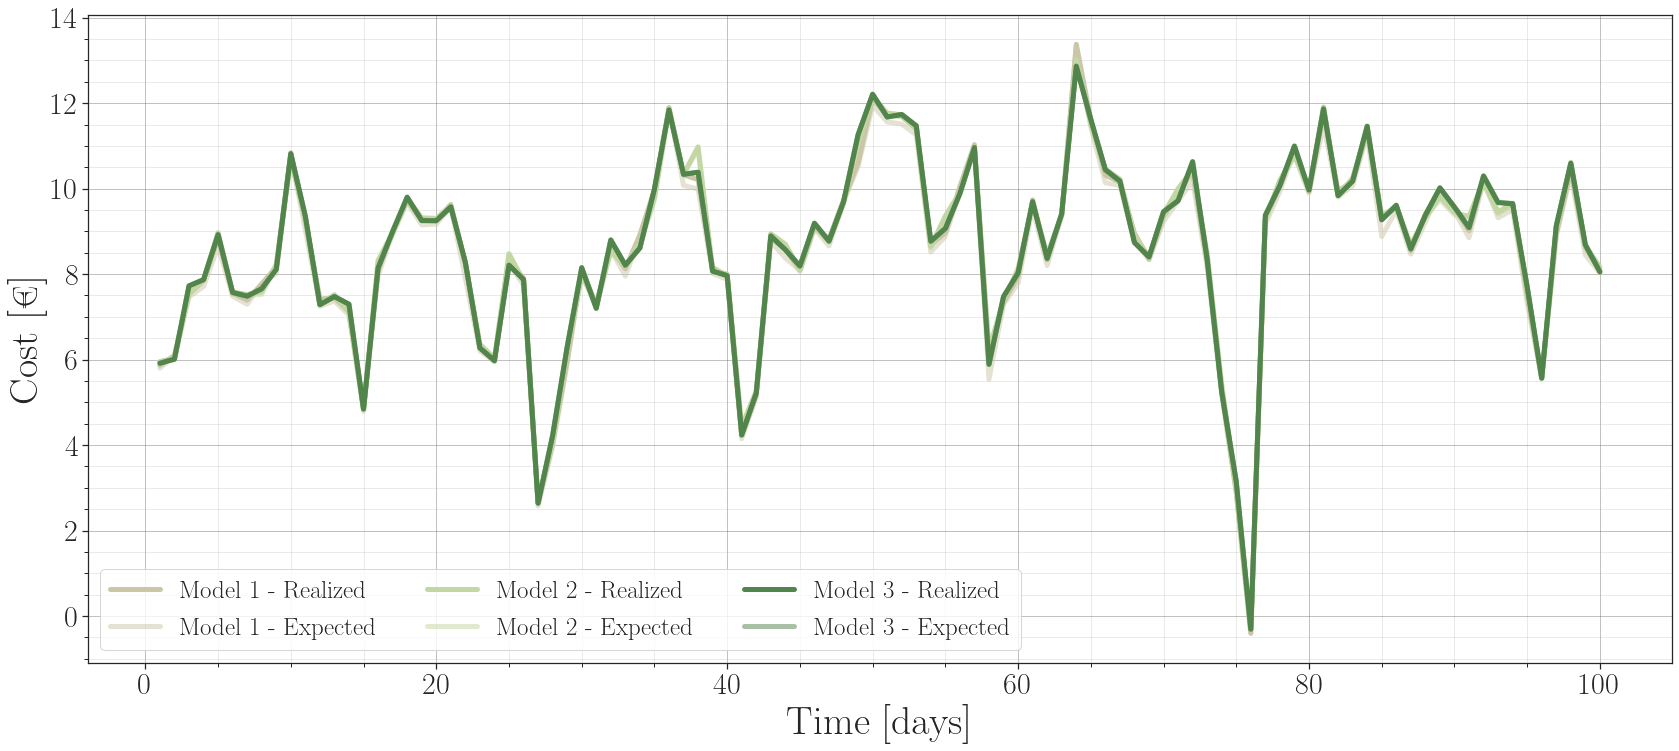

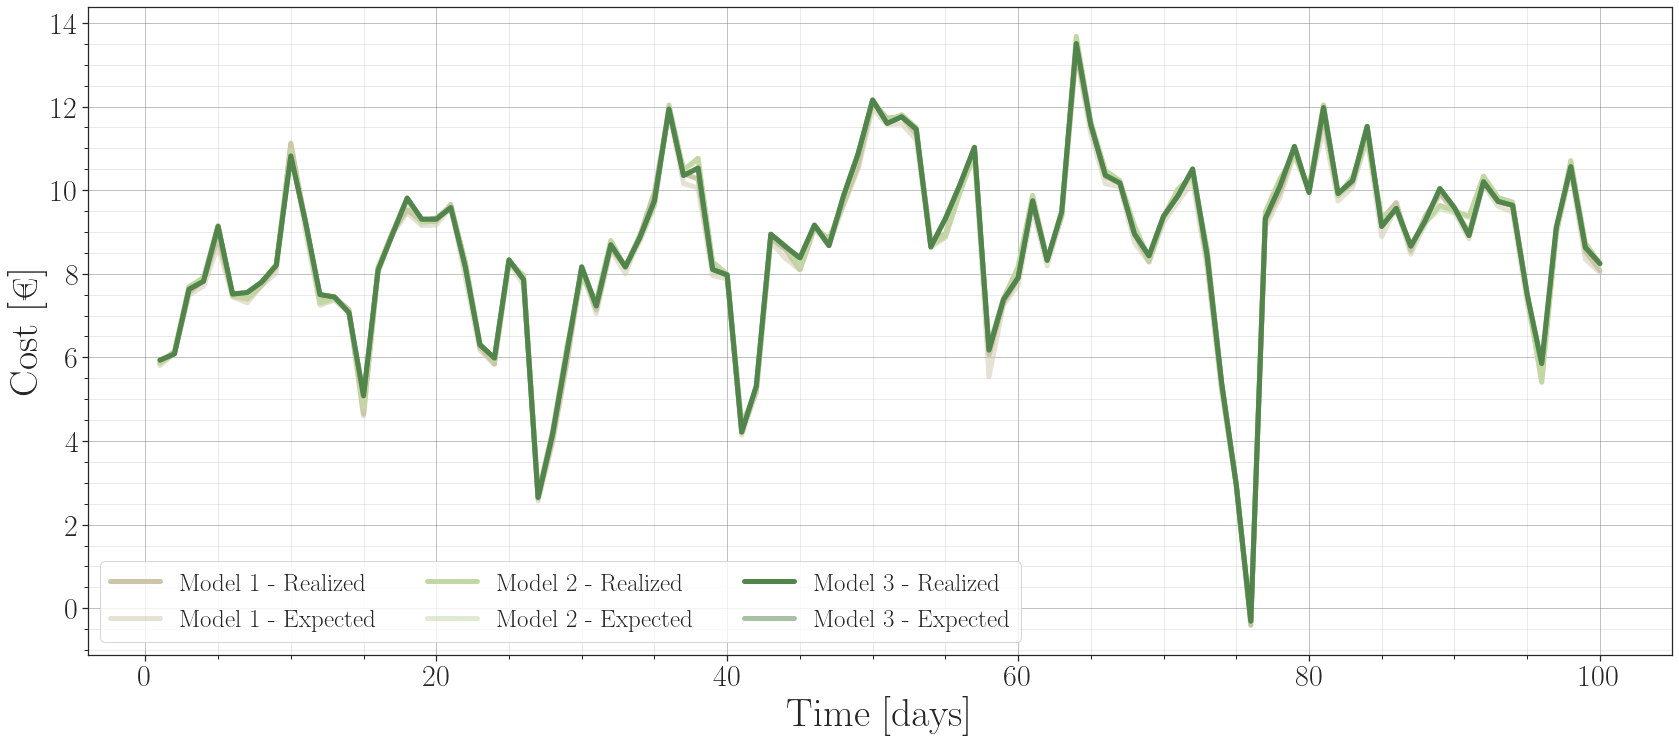

In [123]:
fig = plt.figure(figsize=(25,10))  
ax = fig.add_subplot(111)
linewidth=5
time = np.arange(1,101,1)
ax.plot(time,price_m1_02,label= r'$\textnormal{Model 1 - Realized}$',color=col_mod1_line,linewidth=linewidth)
ax.plot(time,price_m1_02_exp,label= r'$\textnormal{Model 1 - Expected}$',color=col_mod1_line,alpha = 0.5,linewidth=linewidth)

ax.plot(time,price_m2_02,label= r'$\textnormal{Model 2 - Realized}$',color=col_mod2,linewidth=linewidth)
ax.plot(time,price_m2_02_exp,label= r'$\textnormal{Model 2 - Expected}$',color=col_mod2,alpha = 0.5,linewidth=linewidth)

ax.plot(time,price_m3_02,label= r'$\textnormal{Model 3 - Realized}$',color=col_mod3,linewidth=linewidth)
ax.plot(time,price_m3_02_exp,label= r'$\textnormal{Model 3 - Expected}$',color=col_mod3,alpha = 0.5,linewidth=linewidth)
setupAxis(ax)
ax.legend(ncol=3,loc='lower left',prop={'size': 25})
ax.set_ylabel(r'$\textnormal{Cost [€]} $')
ax.set_xlabel(r'$\textnormal{Time [days]} $')


plt.subplots_adjust(hspace = 0.,bottom=0.05, top =0.95,left = 0.07, right = 0.95,)
plt.savefig(FIGS + '/simulation/rk_longterm_cost_ts_02_no_diff.pdf',format='pdf')

fig = plt.figure(figsize=(25,10))  
ax = fig.add_subplot(111)
linewidth=5
time = np.arange(1,101,1)
ax.plot(time,price_m1_05,label= r'$\textnormal{Model 1 - Realized}$',color=col_mod1_line,linewidth=linewidth)
ax.plot(time,price_m1_05_exp,label= r'$\textnormal{Model 1 - Expected}$',color=col_mod1_line,alpha = 0.5,linewidth=linewidth)

ax.plot(time,price_m2_05,label= r'$\textnormal{Model 2 - Realized}$',color=col_mod2,linewidth=linewidth)
ax.plot(time,price_m2_05_exp,label= r'$\textnormal{Model 2 - Expected}$',color=col_mod2,alpha = 0.5,linewidth=linewidth)

ax.plot(time,price_m3_05,label= r'$\textnormal{Model 3 - Realized}$',color=col_mod3,linewidth=linewidth)
ax.plot(time,price_m3_05_exp,label= r'$\textnormal{Model 3 - Expected}$',color=col_mod3,alpha = 0.5,linewidth=linewidth)
setupAxis(ax)
ax.legend(ncol=3,loc='lower left',prop={'size': 25})
ax.set_ylabel(r'$\textnormal{Cost [€]} $')
ax.set_xlabel(r'$\textnormal{Time [days]} $')


plt.subplots_adjust(hspace = 0.,bottom=0.05, top =0.95,left = 0.07, right = 0.95,)
plt.savefig(FIGS + '/simulation/rk_longterm_cost_ts_05_no_diff.pdf',format='pdf')



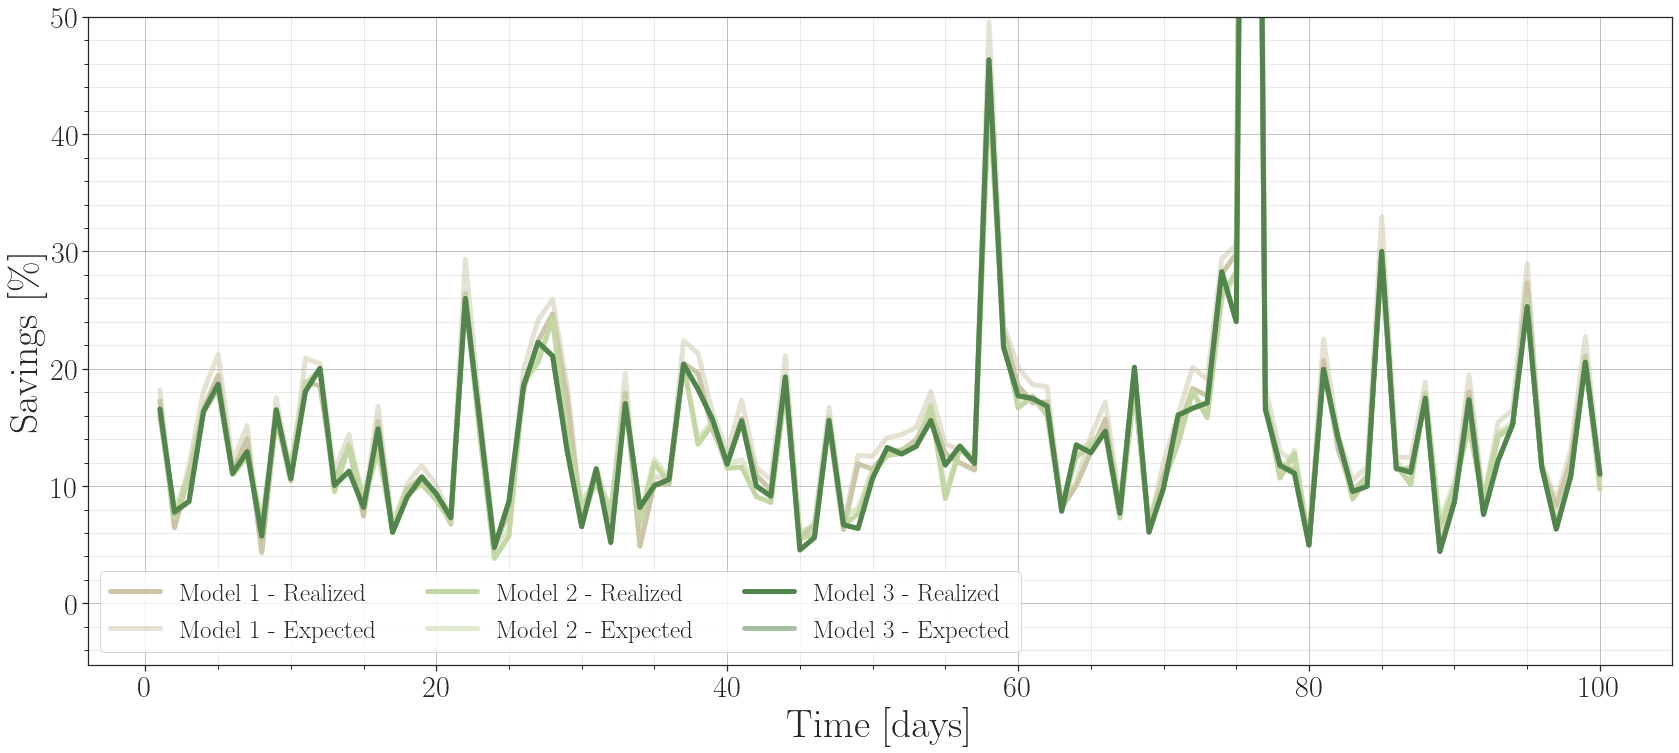

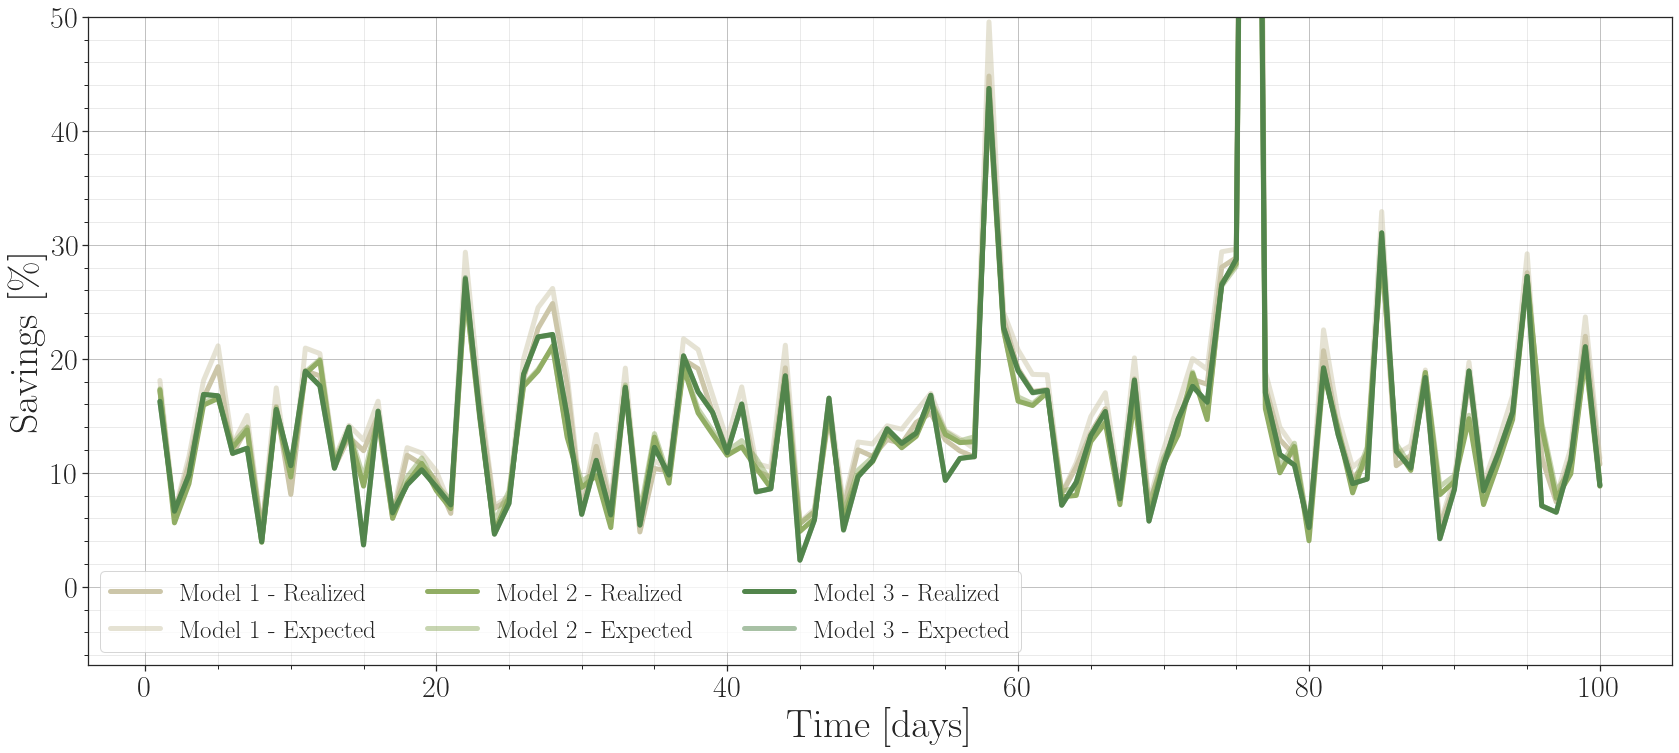

In [125]:
fig = plt.figure(figsize=(25,10))  
ax = fig.add_subplot(111)
time = np.arange(1,101,1)
linewidth=5
ax.plot(time,save_m1_02,label= r'$\textnormal{Model 1 - Realized}$',color=col_mod1_line,linewidth=linewidth)
ax.plot(time,save_m1_02_exp,label= r'$\textnormal{Model 1 - Expected}$',color=col_mod1_line,alpha = 0.5,linewidth=linewidth)

ax.plot(time,save_m2_02,label= r'$\textnormal{Model 2 - Realized}$',color=col_mod2,linewidth=linewidth)
ax.plot(time,save_m2_02_exp,label= r'$\textnormal{Model 2 - Expected}$',color=col_mod2,alpha = 0.5,linewidth=linewidth)

ax.plot(time,save_m3_02,label= r'$\textnormal{Model 3 - Realized}$',color=col_mod3,linewidth=linewidth)
ax.plot(time,save_m3_02_exp,label= r'$\textnormal{Model 3 - Expected}$',color=col_mod3,alpha = 0.5,linewidth=linewidth)
setupAxis(ax)
ax.legend(ncol=3,loc='lower left',prop={'size': 25})
ax.set_ylabel(r'$\textnormal{Savings [\%]} $')
ax.set_xlabel(r'$\textnormal{Time [days]} $')

ax.set_ylim(ymax=50)

plt.subplots_adjust(hspace = 0.,bottom=0.05, top =0.95,left = 0.07, right = 0.95,)
plt.savefig(FIGS + '/simulation/rk_longterm_save_ts_02_no_diff.pdf',format='pdf')

fig = plt.figure(figsize=(25,10))  
ax = fig.add_subplot(111)
time = np.arange(1,101,1)
linewidth=5
ax.plot(time,save_m1_05,label= r'$\textnormal{Model 1 - Realized}$',color=col_mod1_line,linewidth=linewidth)
ax.plot(time,save_m1_05_exp,label= r'$\textnormal{Model 1 - Expected}$',color=col_mod1_line,alpha = 0.5,linewidth=linewidth)

ax.plot(time,save_m2_05,label= r'$\textnormal{Model 2 - Realized}$',color=col_mod2_line,linewidth=linewidth)
ax.plot(time,save_m2_05_exp,label= r'$\textnormal{Model 2 - Expected}$',color=col_mod2_line,alpha = 0.5,linewidth=linewidth)

ax.plot(time,save_m3_05,label= r'$\textnormal{Model 3 - Realized}$',color=col_mod3,linewidth=linewidth)
ax.plot(time,save_m3_05_exp,label= r'$\textnormal{Model 3 - Expected}$',color=col_mod3,alpha = 0.5,linewidth=linewidth)
setupAxis(ax)
ax.legend(ncol=3,loc='lower left',prop={'size': 25})
ax.set_ylabel(r'$\textnormal{Savings [\%]} $')
ax.set_xlabel(r'$\textnormal{Time [days]} $')

ax.set_ylim(ymax=50)

plt.subplots_adjust(hspace = 0.,bottom=0.05, top =0.95,left = 0.07, right = 0.95,)
plt.savefig(FIGS + '/simulation/rk_longterm_save_ts_05_no_diff.pdf',format='pdf')



No handles with labels found to put in legend.


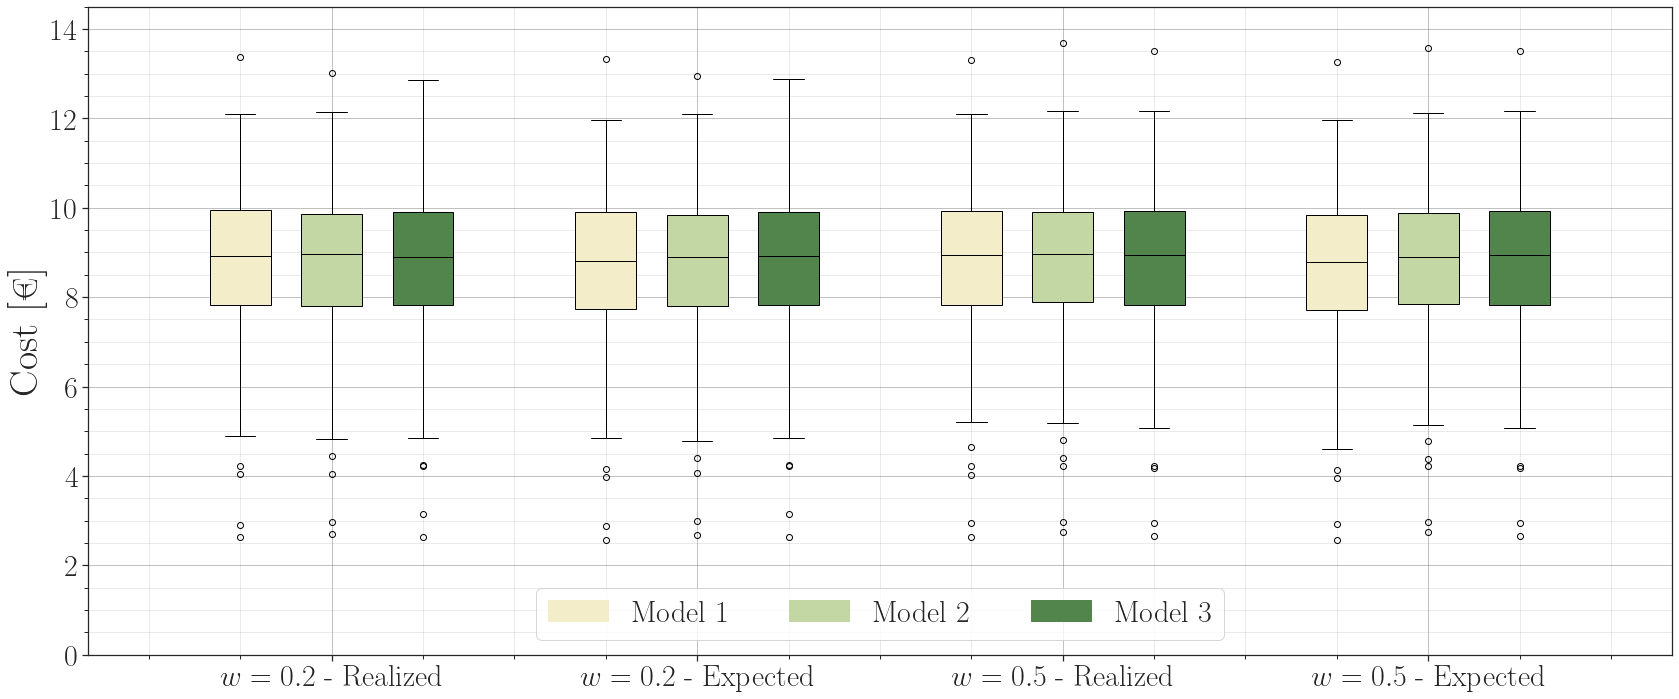

In [126]:
def set_box_color(bp, color_box, color_whish, col_caps, col_median, col_fill):
    plt.setp(bp['boxes'], color=color_box)
    plt.setp(bp['whiskers'], color=color_whish)
    plt.setp(bp['caps'], color=col_caps)
    plt.setp(bp['medians'], color=col_median)
    
    for box in bp['boxes']:
        box.set(facecolor = col_fill) 
    
fig = plt.figure(figsize=(25,10))   
ax1 = fig.add_subplot(111)
boxplot_data_m1 = np.vstack( (price_m1_02,price_m1_02_exp, price_m1_05,price_m1_05_exp))
boxplot_data_m2 = np.vstack( (price_m2_02,price_m2_02_exp, price_m2_05,price_m2_05_exp))
boxplot_data_m3 = np.vstack( (price_m3_02,price_m3_02_exp, price_m3_05,price_m3_05_exp))
bpl = ax1.boxplot(boxplot_data_m1.T, positions=np.array(range(len(boxplot_data_m1)))*1.2-0.3, widths=0.2, patch_artist=True)
bpr = ax1.boxplot(boxplot_data_m2.T, positions=np.array(range(len(boxplot_data_m2)))*1.2, widths=0.2, patch_artist=True)
bp3 = ax1.boxplot(boxplot_data_m3.T, positions=np.array(range(len(boxplot_data_m3)))*1.2+0.3, widths=0.2, patch_artist=True)


#print(colors1[5])
set_box_color(bpl, color_box = 'black', color_whish = 'black', col_caps = 'black', col_median = 'black',\
              col_fill = col_mod1)
set_box_color(bpr, color_box = 'black', color_whish = 'black', col_caps = 'black', col_median = 'black',\
              col_fill = col_mod2)
set_box_color(bp3, color_box = 'black', color_whish = 'black', col_caps = 'black', col_median = 'black',\
              col_fill = col_mod3)

setupAxis(ax1)
#ax1.set_xticks(range(0,6,2))
#ax1.set_xticklabels([r'$\textnormal{Model 1}$',r'$\textnormal{Model 1}$',r'$\textnormal{Model 1}$'])
ax1.yaxis.grid(True) # Hide the horizontal gridlines
#ax1.set_xlabel(r'$\textnormal{Number of cycles}$')
ax1.set_ylabel(r'$\textnormal{Cost [€]} $')
ax1.set_xticks(np.array([0,1.2,2.4,3.6]))
ax1.set_xticklabels([r'$w = 0.2\textnormal{ - Realized}$',r'$w = 0.2\textnormal{ - Expected}$',r'$w = 0.5\textnormal{ - Realized}$',r'$w = 0.5\textnormal{ - Expected}$'])
ax1.yaxis.grid(True) # Hide the horizontal gridlines
ax1.set_xlabel(r'')
ax1.set_ylabel(r'$\textnormal{Cost [€]} $')
ax1.minorticks_on()
ax1.set_ylim(0,14.5)
#ax1.set_xlim(-1.5,19)
model1_patch = mpatches.Patch(color=col_mod1, label=r'$\textnormal{Model 1} $')
model2_patch = mpatches.Patch(color=col_mod2, label=r'$\textnormal{Model 2} $')
model3_patch = mpatches.Patch(color=col_mod3, label=r'$\textnormal{Model 3} $')
ax1.legend(handles=[model1_patch, model2_patch, model3_patch],prop={'size': 30},ncol=4,loc='lower center')

plt.subplots_adjust(hspace = 0.,bottom=0.05, top =0.95,left = 0.07, right = 0.95,)

plt.savefig(FIGS + '/simulation/rk_longterm_boxplot_no_diff.pdf',format='pdf')


No handles with labels found to put in legend.
No handles with labels found to put in legend.


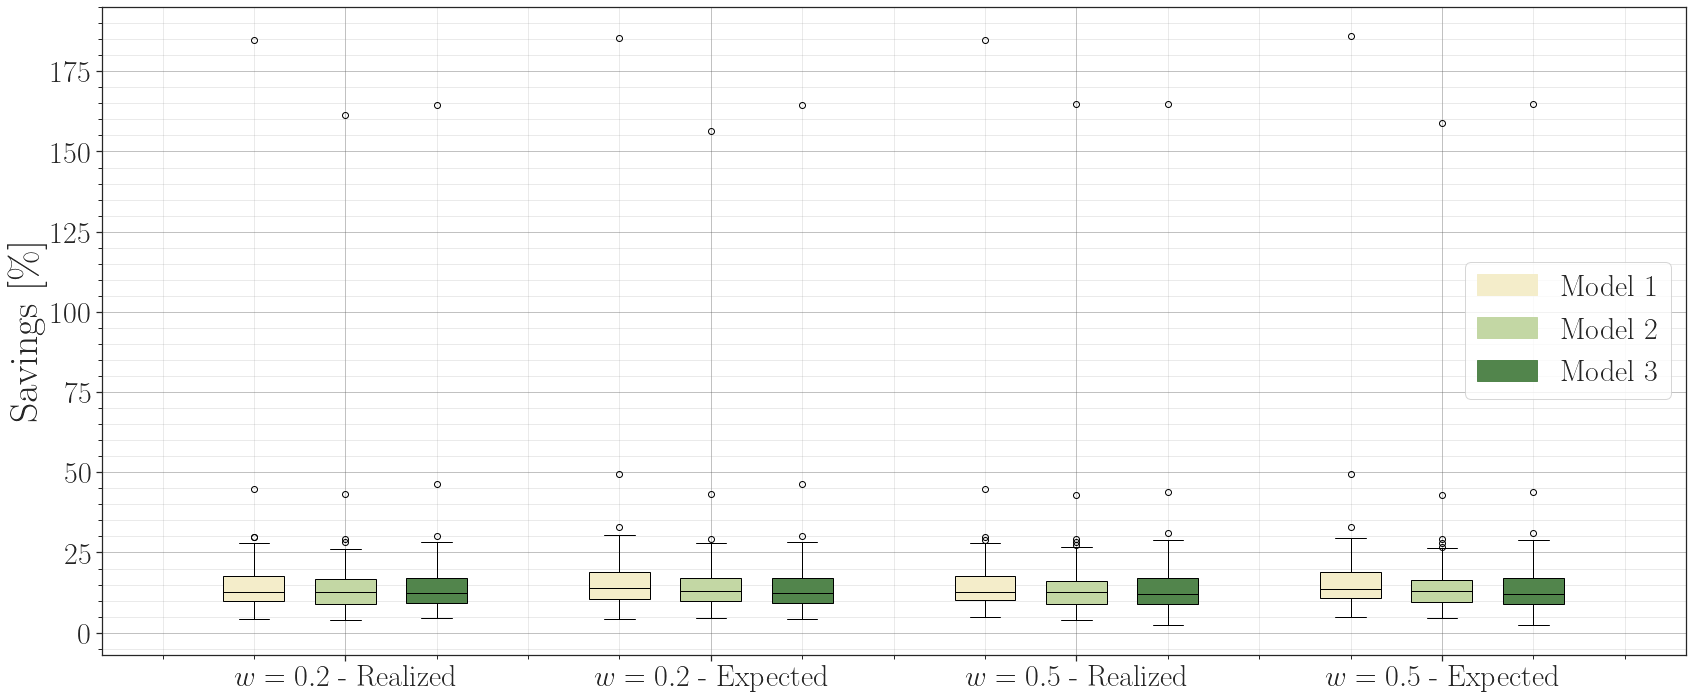

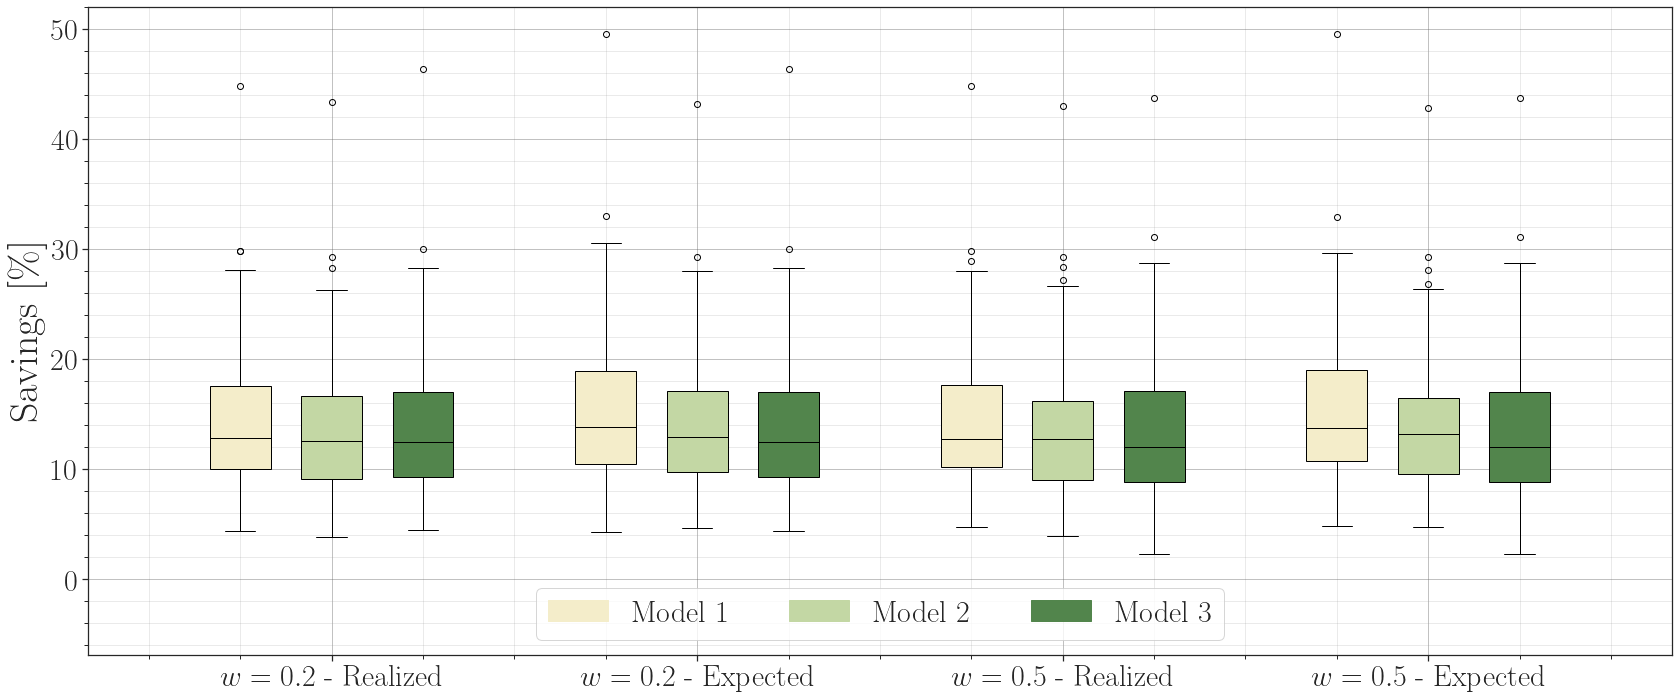

In [127]:
def set_box_color(bp, color_box, color_whish, col_caps, col_median, col_fill):
    plt.setp(bp['boxes'], color=color_box)
    plt.setp(bp['whiskers'], color=color_whish)
    plt.setp(bp['caps'], color=col_caps)
    plt.setp(bp['medians'], color=col_median)
    
    for box in bp['boxes']:
        box.set(facecolor = col_fill) 
    
fig = plt.figure(figsize=(25,10))   
ax1 = fig.add_subplot(111)
boxplot_data_m1 = np.vstack( (save_m1_02,save_m1_02_exp, save_m1_05,save_m1_05_exp))
boxplot_data_m2 = np.vstack( (save_m2_02,save_m2_02_exp, save_m2_05,save_m2_05_exp))
boxplot_data_m3 = np.vstack( (save_m3_02,save_m3_02_exp, save_m3_05,save_m3_05_exp))
bpl = ax1.boxplot(boxplot_data_m1.T, positions=np.array(range(len(boxplot_data_m1)))*1.2-0.3, widths=0.2, patch_artist=True)
bpr = ax1.boxplot(boxplot_data_m2.T, positions=np.array(range(len(boxplot_data_m2)))*1.2, widths=0.2, patch_artist=True)
bp3 = ax1.boxplot(boxplot_data_m3.T, positions=np.array(range(len(boxplot_data_m3)))*1.2+0.3, widths=0.2, patch_artist=True)


#print(colors1[5])
set_box_color(bpl, color_box = 'black', color_whish = 'black', col_caps = 'black', col_median = 'black',\
              col_fill = col_mod1)
set_box_color(bpr, color_box = 'black', color_whish = 'black', col_caps = 'black', col_median = 'black',\
              col_fill = col_mod2)
set_box_color(bp3, color_box = 'black', color_whish = 'black', col_caps = 'black', col_median = 'black',\
              col_fill = col_mod3)

setupAxis(ax1)
#ax1.set_xticks(range(0,6,2))
#ax1.set_xticklabels([r'$\textnormal{Model 1}$',r'$\textnormal{Model 1}$',r'$\textnormal{Model 1}$'])
ax1.yaxis.grid(True) # Hide the horizontal gridlines
#ax1.set_xlabel(r'$\textnormal{Number of cycles}$')
ax1.set_ylabel(r'$\textnormal{Cost [€]} $')
ax1.set_xticks(np.array([0,1.2,2.4,3.6]))
ax1.set_xticklabels([r'$w = 0.2\textnormal{ - Realized}$',r'$w = 0.2\textnormal{ - Expected}$',r'$w = 0.5\textnormal{ - Realized}$',r'$w = 0.5\textnormal{ - Expected}$'])
ax1.yaxis.grid(True) # Hide the horizontal gridlines
ax1.set_xlabel(r'')
ax1.set_ylabel(r'$\textnormal{Savings [\%]} $')
ax1.minorticks_on()
#ax1.set_ylim(0,1)
#ax1.set_xlim(-1.5,19)
model1_patch = mpatches.Patch(color=col_mod1, label=r'$\textnormal{Model 1} $')
model2_patch = mpatches.Patch(color=col_mod2, label=r'$\textnormal{Model 2} $')
model3_patch = mpatches.Patch(color=col_mod3, label=r'$\textnormal{Model 3} $')
ax1.legend(handles=[model1_patch, model2_patch, model3_patch],prop={'size': 30},ncol=1,loc='center right')

plt.subplots_adjust(hspace = 0.,bottom=0.05, top =0.95,left = 0.07, right = 0.95,)

plt.subplots_adjust(hspace = 0.,bottom=0.05, top =0.95,left = 0.07, right = 0.95,)
plt.savefig(FIGS + '/simulation/rk_longterm_boxplot_save_no_diff.pdf',format='pdf')


fig = plt.figure(figsize=(25,10))   
ax1 = fig.add_subplot(111)

bpl = ax1.boxplot(boxplot_data_m1.T, positions=np.array(range(len(boxplot_data_m1)))*1.2-0.3, widths=0.2, patch_artist=True)
bpr = ax1.boxplot(boxplot_data_m2.T, positions=np.array(range(len(boxplot_data_m2)))*1.2, widths=0.2, patch_artist=True)
bp3 = ax1.boxplot(boxplot_data_m3.T, positions=np.array(range(len(boxplot_data_m3)))*1.2+0.3, widths=0.2, patch_artist=True)


#print(colors1[5])
set_box_color(bpl, color_box = 'black', color_whish = 'black', col_caps = 'black', col_median = 'black',\
              col_fill = col_mod1)
set_box_color(bpr, color_box = 'black', color_whish = 'black', col_caps = 'black', col_median = 'black',\
              col_fill = col_mod2)
set_box_color(bp3, color_box = 'black', color_whish = 'black', col_caps = 'black', col_median = 'black',\
              col_fill = col_mod3)

setupAxis(ax1)
#ax1.set_xticks(range(0,6,2))
#ax1.set_xticklabels([r'$\textnormal{Model 1}$',r'$\textnormal{Model 1}$',r'$\textnormal{Model 1}$'])
ax1.yaxis.grid(True) # Hide the horizontal gridlines
#ax1.set_xlabel(r'$\textnormal{Number of cycles}$')
ax1.set_ylabel(r'$\textnormal{Cost [€]} $')
ax1.set_xticks(np.array([0,1.2,2.4,3.6]))
ax1.set_xticklabels([r'$w = 0.2\textnormal{ - Realized}$',r'$w = 0.2\textnormal{ - Expected}$',r'$w = 0.5\textnormal{ - Realized}$',r'$w = 0.5\textnormal{ - Expected}$'])
ax1.yaxis.grid(True) # Hide the horizontal gridlines
ax1.set_xlabel(r'')
ax1.set_ylabel(r'$\textnormal{Savings [\%]} $')
ax1.minorticks_on()
#ax1.set_ylim(0,1)
#ax1.set_xlim(-1.5,19)
model1_patch = mpatches.Patch(color=col_mod1, label=r'$\textnormal{Model 1} $')
model2_patch = mpatches.Patch(color=col_mod2, label=r'$\textnormal{Model 2} $')
model3_patch = mpatches.Patch(color=col_mod3, label=r'$\textnormal{Model 3} $')
ax1.legend(handles=[model1_patch, model2_patch, model3_patch],prop={'size': 30},ncol=4,loc='lower center')

ax1.set_ylim(ymax=52)
plt.subplots_adjust(hspace = 0.,bottom=0.05, top =0.95,left = 0.07, right = 0.95,)

plt.subplots_adjust(hspace = 0.,bottom=0.05, top =0.95,left = 0.07, right = 0.95,)
plt.savefig(FIGS + '/simulation/rk_longterm_boxplot_save_zoom_no_diff.pdf',format='pdf')


/Users/madsobdrup/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: RuntimeWarning: invalid value encountered in true_divide
/Users/madsobdrup/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in true_divide
/Users/madsobdrup/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:118: RuntimeWarning: invalid value encountered in true_divide
/Users/madsobdrup/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:119: RuntimeWarning: invalid value encountered in true_divide
/Users/madsobdrup/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:120: RuntimeWarning: invalid value encountered in true_divide


spot                      33.44
down                      33.44
up                        33.44
market_spot                   1
market_down                   0
market_up                     0
RK                        33.44
t_sin               1.22465e-16
market_class_all              1
Name: 2018-03-03 12:00:00, dtype: object


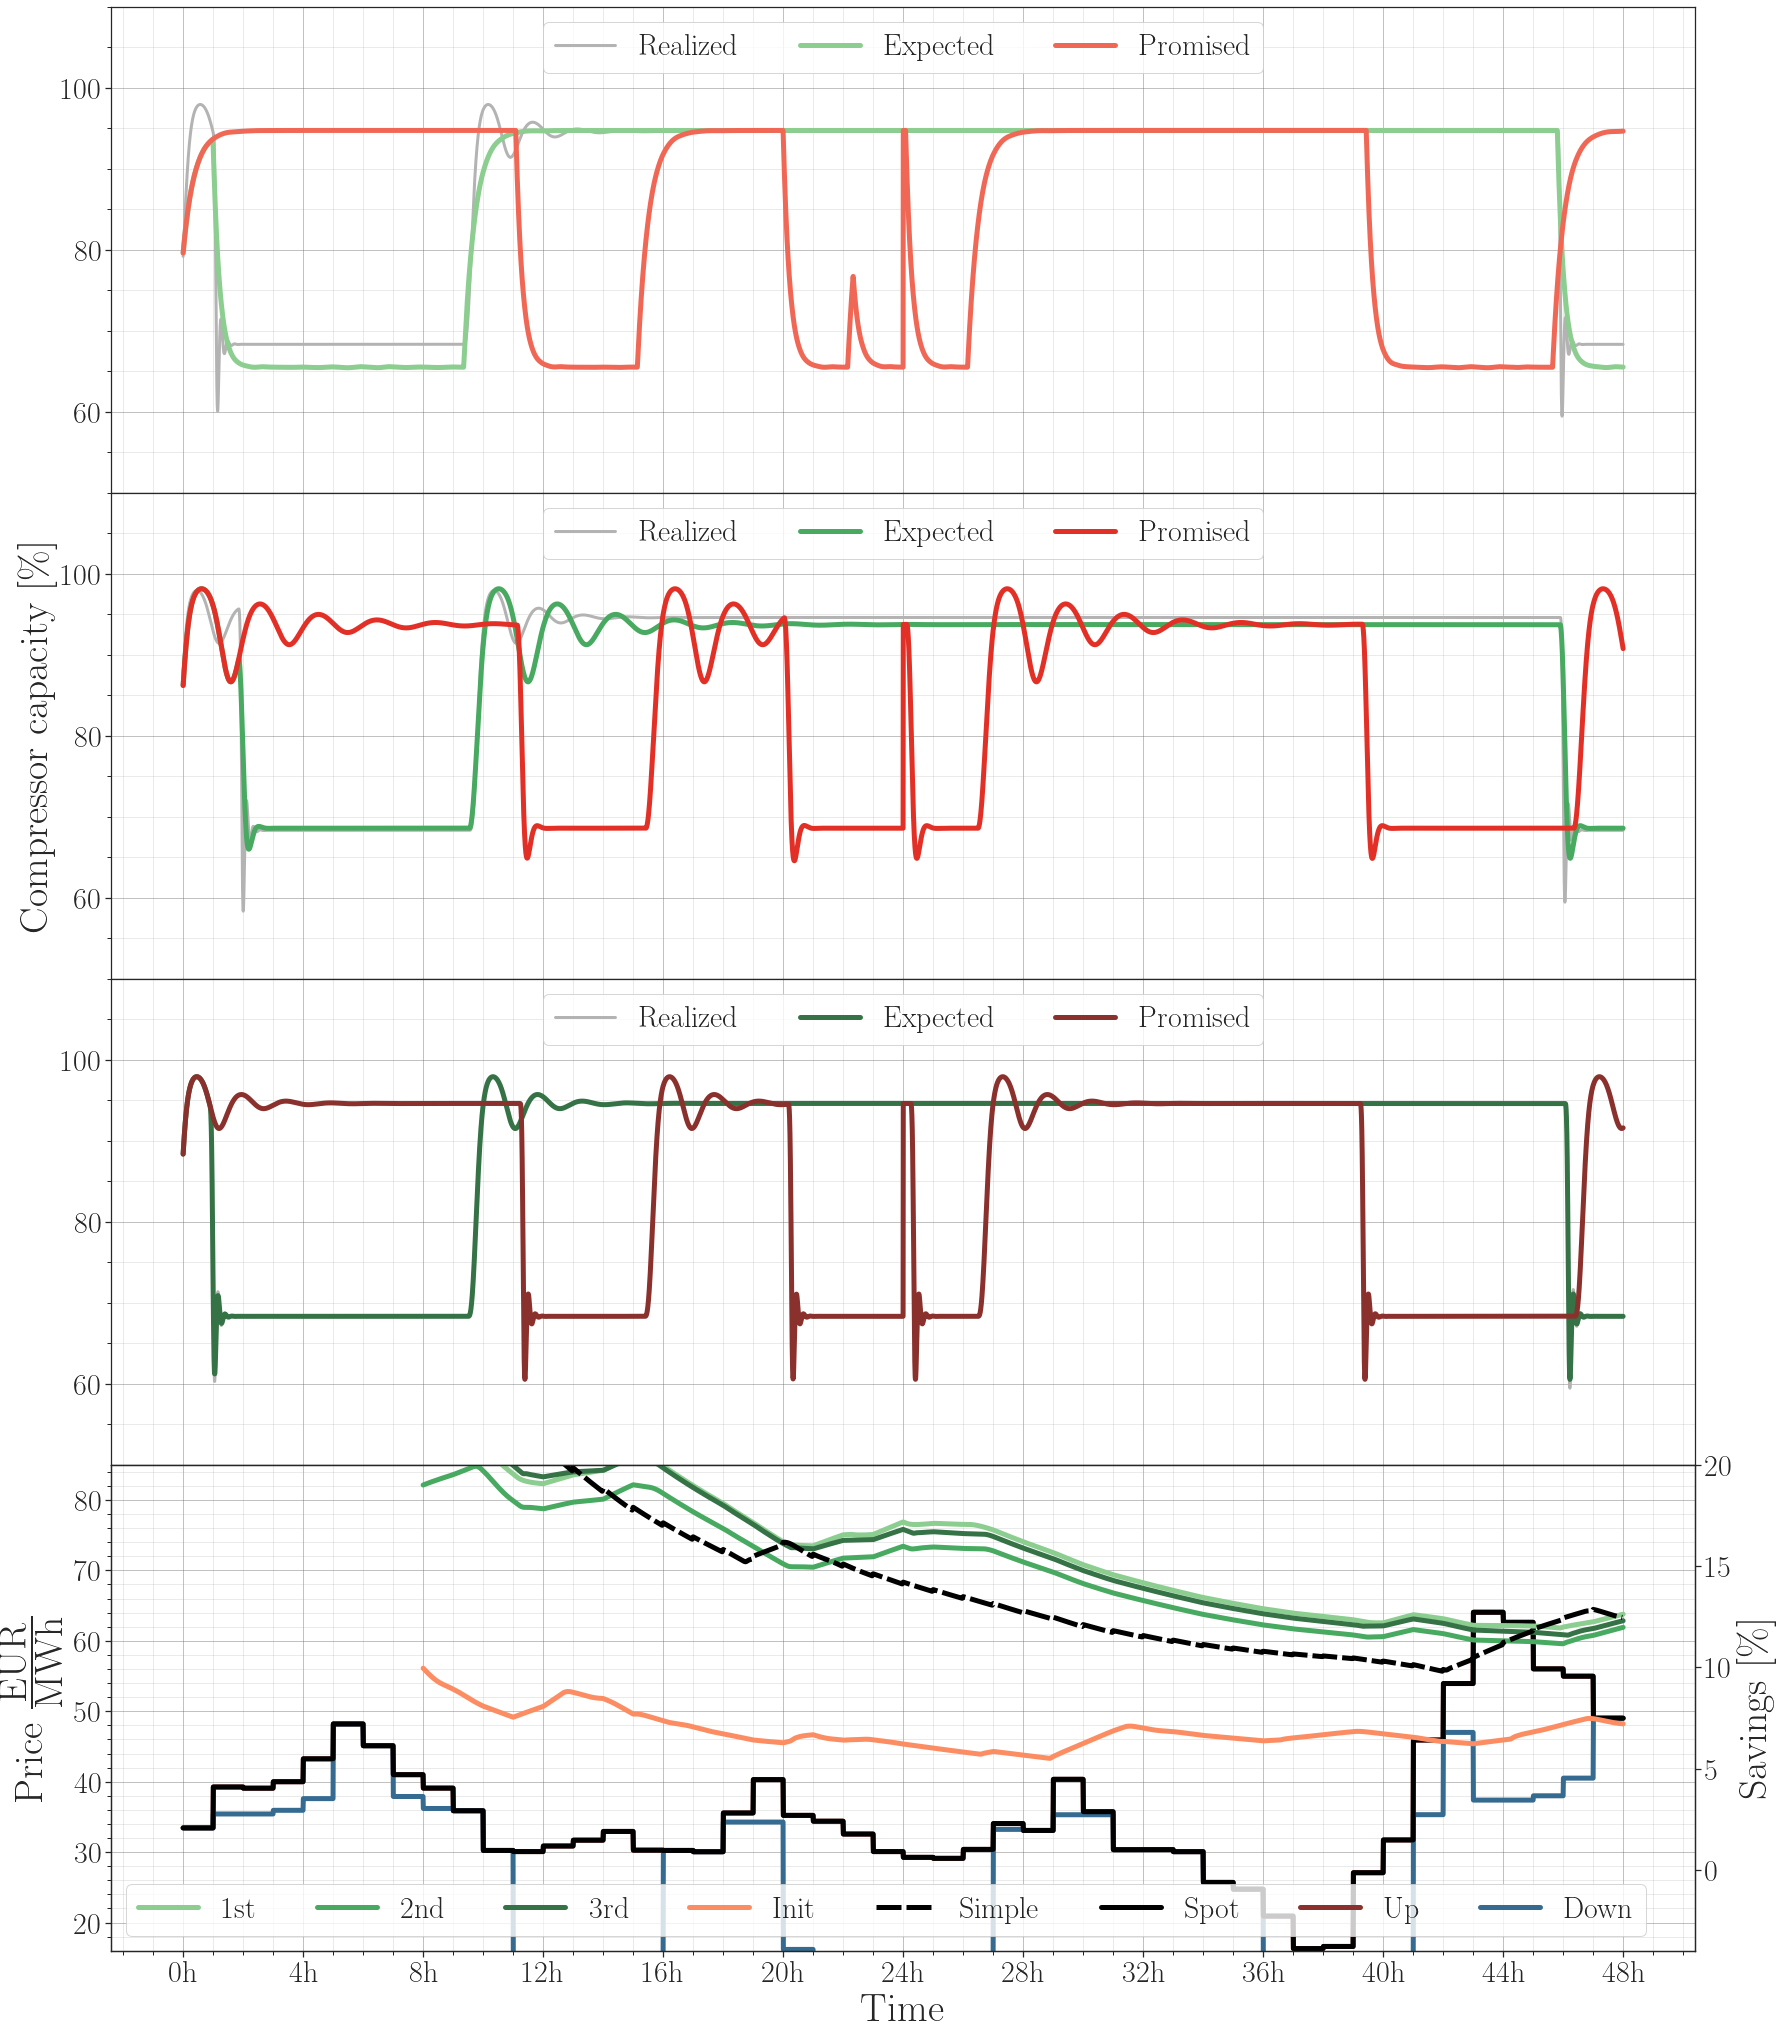

In [129]:
price_slope = 1.
#days_to_plot = range(55,57)
days_to_plot = range(61,63)
linewidth1 = 3
linewidth2 = 5
n_skip_x = 4
histories = histories_02

fig = plt.figure(figsize=(25,30))   
ax1 = fig.add_subplot(411)

price_idle_plot =np.concatenate([histories_02_reuse['price_true_idle'][day] for day in days_to_plot]) - histories_02_reuse['price_true_idle'][days_to_plot[0]][0]

model = 'm1'
Z_model_true_plot_m1 =np.concatenate([histories[model]['Z_true'][day][0] for day in days_to_plot])
Z_model_rk_plot_m1 = np.concatenate([histories[model]['Z_model_rk'][day][0] for day in days_to_plot])
Z_model_dap_plot_m1 = np.concatenate([histories[model]['Z_model_promised'][day][0] for day in days_to_plot])
T_plot = np.concatenate([histories[model]['T'][0] + day * 60*24 for day in days_to_plot])
price_true_plot_m1 =np.concatenate([histories[model]['price_true'][day] for day in days_to_plot]) - histories[model]['price_true'][days_to_plot[0]][0]

ax1.plot(T_plot,100*Z_model_true_plot_m1,markersize=10,color = sns.color_palette("Set2")[-1], label=r'$\textnormal{Realized}$',alpha = 1.,linewidth=linewidth1)
ax1.plot(T_plot ,100*Z_model_rk_plot_m1,color = greens[5], label=r'$\textnormal{Expected}$',linewidth=linewidth2)
ax1.plot(T_plot ,100*Z_model_dap_plot_m1,color = red[5], label=r'$\textnormal{Promised}$',linewidth=linewidth2)

total_number_of_days = (days_to_plot[-1] - days_to_plot[0]) + 1
ax1.set_xticks(np.arange(0,total_number_of_days*25,n_skip_x)*(60.) + days_to_plot[0] * 60 * 24)
ax1.set_xticklabels(['' for _t in np.arange(0,total_number_of_days*25,n_skip_x) * 60.])
ax1.set_yticks([60, 80, 100])
setupAxis(ax1,ncol_legend = 3)
ax1.set_xlabel(r'')
ax1.set_ylabel(r'')
ax1.set_ylim(50,110)
ax1.legend(prop={'size': 30},ncol=3,loc = 'upper center')


 
ax2 = fig.add_subplot(412)

model = 'm2'
Z_model_true_plot_m2 =np.concatenate([histories[model]['Z_true'][day][0] for day in days_to_plot])
Z_model_rk_plot_m2 = np.concatenate([histories[model]['Z_model_rk'][day][0] for day in days_to_plot])
Z_model_dap_plot_m2 = np.concatenate([histories[model]['Z_model_promised'][day][0] for day in days_to_plot])
T_plot = np.concatenate([histories[model]['T'][0] + day * 60*24 for day in days_to_plot])
price_true_plot_m2 =np.concatenate([histories[model]['price_true'][day] for day in days_to_plot]) - histories[model]['price_true'][days_to_plot[0]][0]

ax2.plot(T_plot,100*Z_model_true_plot_m2,markersize=10,color = sns.color_palette("Set2")[-1], label=r'$\textnormal{Realized}$',alpha = 1.,linewidth=linewidth1)
ax2.plot(T_plot ,100*Z_model_rk_plot_m2,color = greens[3], label=r'$\textnormal{Expected}$',linewidth=linewidth2)
ax2.plot(T_plot ,100*Z_model_dap_plot_m2,color = red[3], label=r'$\textnormal{Promised}$',linewidth=linewidth2)

total_number_of_days = (days_to_plot[-1] - days_to_plot[0]) + 1
ax2.set_xticks(np.arange(0,total_number_of_days*25,n_skip_x)*(60.) + days_to_plot[0] * 60 * 24)
ax2.set_xticklabels(['' for _t in np.arange(0,total_number_of_days*25,n_skip_x) * 60.])
ax2.set_yticks([60, 80, 100])
setupAxis(ax2,ncol_legend = 3)
ax2.set_ylabel(r'$\textnormal{Compressor capacity [\%]} $')
ax2.set_xlabel(r'')
ax2.set_ylim(50,110)
ax2.legend(prop={'size': 30},ncol=3,loc = 'upper center')



  
ax3 = fig.add_subplot(413)
model = 'm3'
Z_model_true_plot_m3 =np.concatenate([histories[model]['Z_true'][day][0] for day in days_to_plot])
Z_model_rk_plot_m3 = np.concatenate([histories[model]['Z_model_rk'][day][0] for day in days_to_plot])
Z_model_dap_plot_m3 = np.concatenate([histories[model]['Z_model_promised'][day][0] for day in days_to_plot])
T_plot = np.concatenate([histories[model]['T'][0] + day * 60*24 for day in days_to_plot])
price_true_plot_m3 =np.concatenate([histories[model]['price_true'][day] for day in days_to_plot]) - histories[model]['price_true'][days_to_plot[0]][0]

ax3.plot(T_plot,100*Z_model_true_plot_m3,markersize=10,color = sns.color_palette("Set2")[-1], label=r'$\textnormal{Realized}$',alpha = 1.,linewidth=linewidth1)
ax3.plot(T_plot ,100*Z_model_rk_plot_m3,color = greens[1], label=r'$\textnormal{Expected}$',linewidth=linewidth2)
ax3.plot(T_plot ,100*Z_model_dap_plot_m3,color = red[1], label=r'$\textnormal{Promised}$',linewidth=linewidth2)

total_number_of_days = (days_to_plot[-1] - days_to_plot[0]) + 1
ax3.set_xticks(np.arange(0,total_number_of_days*25,n_skip_x)*(60.) + days_to_plot[0] * 60 * 24)
ax3.set_xticklabels(['' for _t in np.arange(0,total_number_of_days*25,n_skip_x) * 60.])
ax3.set_yticks([60, 80, 100])
setupAxis(ax3,ncol_legend = 3)
ax3.set_xlabel(r'')
ax3.set_ylabel(r'')
ax3.set_ylim(50,110)
ax3.legend(prop={'size': 30},ncol=3,loc = 'upper center')


price_true_plot_init =np.concatenate([histories[model]['price_true_init_switch'][day] for day in days_to_plot]) - histories[model]['price_true_init_switch'][days_to_plot[0]][0]




ax5 = fig.add_subplot(414)
all_up = np.concatenate([histories[model]['PRICES_up'][day,:24] for day in days_to_plot])
all_down = np.concatenate([histories[model]['PRICES_down'][day,:24] for day in days_to_plot])
all_dap = np.concatenate([histories[model]['PRICES_dap'][day,:24] for day in days_to_plot])
all_time = np.concatenate([histories[model]['T'][0] + day * 60*24 for day in days_to_plot])

# Model one price
price_true_plot_og =np.concatenate([histories_02_dap['m1']['price_true'][day] for day in days_to_plot]) - histories_02_dap['m1']['price_true'][days_to_plot[0]][0]
T_plot_og_dap = np.concatenate([histories_02_dap['m1']['T'][0] + day * 60*24 for day in days_to_plot])

lup = ax5.plot(all_time,smooth_dap(all_time - all_time[0],all_up,100,48),color=red[1],linewidth=linewidth2, label=r'$\textnormal{Up}$')
ldown = ax5.plot(all_time,smooth_dap(all_time - all_time[0],all_down,100,48),color=blue[1],linewidth=linewidth2, label=r'$\textnormal{Down}$')
lprice = ax5.plot(all_time,smooth_dap(all_time - all_time[0],all_dap,100,48),color='black',linewidth=linewidth2, label=r'$\textnormal{Spot}$')

#ax4.plot(all_time,smooth_dap(all_time - all_time[0],all_dap,0.2,48),color=red[2],linewidth=linewidth1)
ax5.set_xticks(np.arange(0,total_number_of_days*25,4)*(60.) + days_to_plot[0] * 60 * 24)
ax5.set_xticklabels(['$'+str(int(_t/60.)) + r' \textnormal{h}$' for _t in np.arange(0,total_number_of_days*25,4) * 60.])
setupAxis(ax5,ncol_legend = 3,nolegend=True)
ax5.set_ylabel(r'$\textnormal{Price } \frac{\textnormal{EUR}}{\textnormal{MWh}}$')
ax5.set_xlabel(r'$\textnormal{Time} $')


ax5.set_ylim(16,85)

ax5_2 = ax5.twinx()
l1 = ax5_2.plot(all_time[2400:],(100*(price_idle_plot - price_true_plot_m1)/price_idle_plot)[2400:],color=greens[5],linewidth=linewidth2, label=r'$\textnormal{1st}$')
l2 = ax5_2.plot(all_time[2400:],(100*(price_idle_plot - price_true_plot_m2)/price_idle_plot)[2400:],color=greens[3],linewidth=linewidth2, label=r'$\textnormal{2nd}$')
l3 = ax5_2.plot(all_time[2400:],(100*(price_idle_plot - price_true_plot_m3)/price_idle_plot)[2400:],color=greens[1],linewidth=linewidth2, label=r'$\textnormal{3rd}$')
l4 = ax5_2.plot(all_time[2400:],(100*(price_idle_plot - price_true_plot_init)/price_idle_plot)[2400:],color=sns.color_palette("Set2")[1],linewidth=linewidth2, label=r'$\textnormal{Init}$')
l5 = ax5_2.plot(all_time[::10][240:],(100*((price_idle_plot[::10] - price_true_plot_og)/price_idle_plot[::10]))[240:],linestyle=exp_line_style,color='black',linewidth=linewidth2, label=r'$\textnormal{Simple}$')


#ax5_2.set_ylim(ymax = 20)
#ax5_2.set_yticks(np.array([0,4,8,12]))
ax5_2.set_ylabel(r'$\textnormal{Savings [\%]}$', fontsize=40)

ax5_2.tick_params(axis="y", labelsize=30)

lns = l1+l2+l3+l4+l5+lprice+lup+ldown
labs = [l.get_label() for l in lns]
ax5_2.legend(lns, labs,ncol=10,prop={'size': 30})
ax5_2.set_ylim(-4,20)




#ax6 = fig.add_subplot(515)
#ax6.plot(T_plot,percent_in_idle_rk)
#ax6.plot(T_plot_og_dap,percent_in_idle_og)



plt.subplots_adjust(hspace = 0.,bottom=0.05, top =0.95,left = 0.07, right = 0.95,)

plt.savefig(FIGS + '/simulation/rk_specific_day_no_diff.pdf',format='pdf')

prices_used = prices['2018-01-01 12:00:00':]
print(prices_used.iloc[(24*days_to_plot[0])])






In [82]:
histories['m3']['price_true'][99], histories['m3']['price_model_rk'][99]

(array([856.39957113, 856.40079398, 856.40201677, ..., 864.44967768,
        864.45069225, 864.45170685]),
 array([856.5547022 , 856.55592468, 856.55714711, ..., 864.60903436,
        864.6100492 , 864.61106408]))

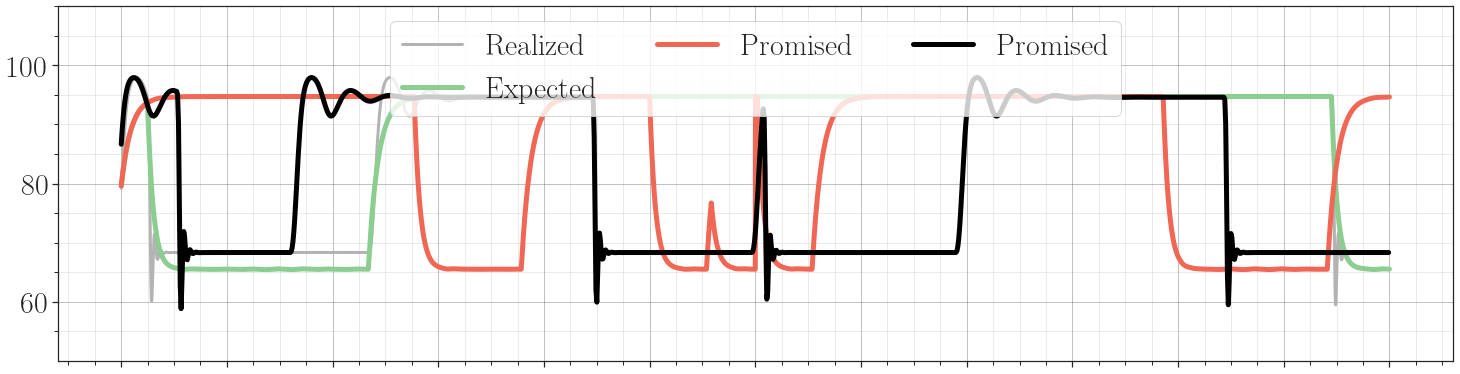

In [130]:
fig = plt.figure(figsize=(25,30))   
ax1 = fig.add_subplot(411)

price_idle_plot =np.concatenate([histories['m1']['price_true_idle'][day] for day in days_to_plot]) - histories['m1']['price_true_idle'][days_to_plot[0]][0]

model = 'm1'
Z_model_true_plot_m1 =np.concatenate([histories[model]['Z_true'][day][0] for day in days_to_plot])
Z_model_rk_plot_m1 = np.concatenate([histories[model]['Z_model_rk'][day][0] for day in days_to_plot])
Z_model_dap_plot_m1 = np.concatenate([histories[model]['Z_model_promised'][day][0] for day in days_to_plot])
T_plot = np.concatenate([histories[model]['T'][0] + day * 60*24 for day in days_to_plot])
price_true_plot_m1 =np.concatenate([histories[model]['price_true'][day] for day in days_to_plot]) - histories[model]['price_true'][days_to_plot[0]][0]

T_plot_og_dap = np.concatenate([histories_02_dap['m1']['T'][0] + day * 60*24 for day in days_to_plot])

ax1.plot(T_plot,100*Z_model_true_plot_m1,markersize=10,color = sns.color_palette("Set2")[-1], label=r'$\textnormal{Realized}$',alpha = 1.,linewidth=linewidth1)
ax1.plot(T_plot ,100*Z_model_rk_plot_m1,color = greens[5], label=r'$\textnormal{Expected}$',linewidth=linewidth2)
ax1.plot(T_plot ,100*Z_model_dap_plot_m1,color = red[5], label=r'$\textnormal{Promised}$',linewidth=linewidth2)
ax1.plot(T_plot_og_dap ,100*Z_og,color = 'black', label=r'$\textnormal{Promised}$',linewidth=linewidth2)

total_number_of_days = (days_to_plot[-1] - days_to_plot[0]) + 1
ax1.set_xticks(np.arange(0,total_number_of_days*25,n_skip_x)*(60.) + days_to_plot[0] * 60 * 24)
ax1.set_xticklabels(['' for _t in np.arange(0,total_number_of_days*25,n_skip_x) * 60.])
ax1.set_yticks([60, 80, 100])
setupAxis(ax1,ncol_legend = 3)
ax1.set_xlabel(r'')
ax1.set_ylabel(r'')
ax1.set_ylim(50,110)
ax1.legend(prop={'size': 30},ncol=3,loc = 'upper center')

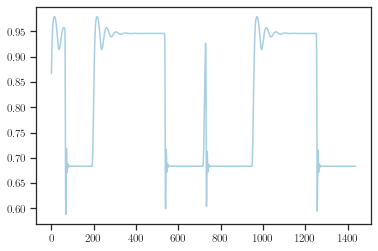

In [45]:
Z_og = np.concatenate([histories_02_dap['m1']['Z_true'][day][0] for day in days_to_plot])
Z_og = np.concatenate([histories_02_dap['m1']['Z_true'][day][0] for day in days_to_plot])
plt.plot(Z_og)

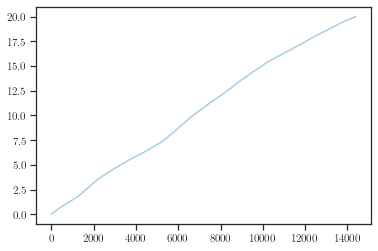

In [201]:
plt.plot(price_true_plot_m1)

In [184]:
all_time.shape[0]/48

300.0

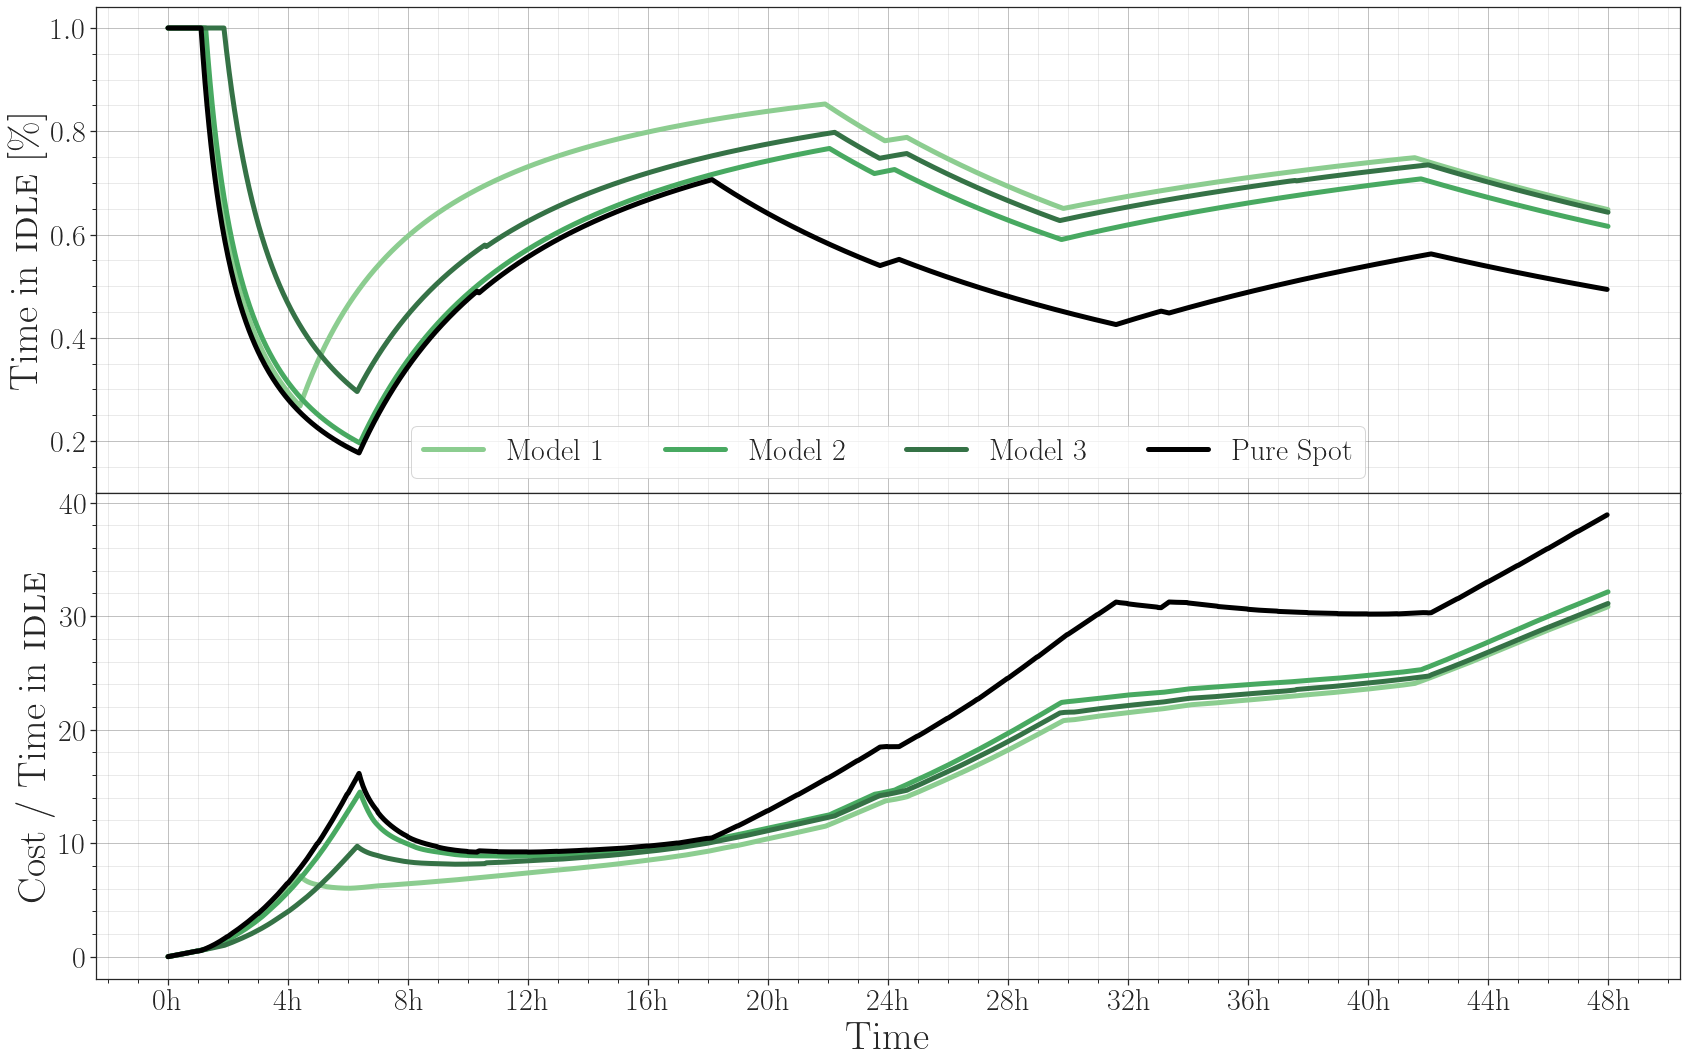

In [199]:
linewidth= 5
percent_in_idle_rk = {}
T_plot_rk = {}
for model in ['m1', 'm2', 'm3']:
    
    T_plot_og_dap = np.concatenate([histories_02_dap['m1']['T'][0] + day * 60*24 for day in days_to_plot])
    T_plot = np.concatenate([histories[model]['T'][0] + day * 60*24 for day in days_to_plot])

    dt_rk = (T_plot[2] - T_plot[1])
    dt_og = (T_plot_og_dap[2] - T_plot_og_dap[1])

    last_time_in_idle_day_rk = 0.
    time_idle_rk = np.array([])

    last_time_in_idle_day_og = 0.
    time_idle_og = np.array([])


    for day in days_to_plot:
        T_day_rk = T_plot[(day*24*60 <= T_plot) & (T_plot<(day+1)*24*60)]
        regime_rk = np.round((1-smooth_regime(T_day_rk,histories_02[model]['SWITCHES_rk'][day] + day*24*60,slope=20000)))
        time_in_idle_day_rk = np.cumsum(regime_rk) * dt_rk + last_time_in_idle_day_rk# - T_day_rk[0]
        last_time_in_idle_day_rk = time_in_idle_day_rk[-1] # Update and append to the time in idle vector
        time_idle_rk = np.append(time_idle_rk, time_in_idle_day_rk)

        T_day_og = T_plot_og_dap[(day*24*60 <= T_plot_og_dap) & (T_plot_og_dap<(day+1)*24*60)]
        regime_og = np.round((1-smooth_regime(T_day_og,histories_02_dap[model]['SWITCHES_dap'][day] + day*24*60,slope=20000)))
        time_in_idle_day_og = np.cumsum(regime_og) * dt_og + last_time_in_idle_day_og# - T_day_og[0]
        last_time_in_idle_day_og = time_in_idle_day_og[-1]
        time_idle_og = np.append(time_idle_og, time_in_idle_day_og)

    percent_in_idle_rk[model] = time_idle_rk/(T_plot - T_plot[0] + dt_rk)
    percent_in_idle_og = time_idle_og/(T_plot_og_dap - T_plot_og_dap[0] + dt_og)    
    
    T_plot_rk[model] = T_plot


fig = plt.figure(figsize=(25,15))   
ax1 = fig.add_subplot(211)

ax1.plot(T_plot_rk['m1'],percent_in_idle_rk['m1'],color = greens[5],linewidth=linewidth,label=r'$\textnormal{Model 1}$')
ax1.plot(T_plot_rk['m2'],percent_in_idle_rk['m2'],color = greens[3],linewidth=linewidth,label=r'$\textnormal{Model 2}$')
ax1.plot(T_plot_rk['m3'],percent_in_idle_rk['m3'],color = greens[1],linewidth=linewidth,label=r'$\textnormal{Model 3}$')
ax1.plot(T_plot_og_dap,percent_in_idle_og,color= 'black',linewidth=linewidth,label=r'$\textnormal{Pure Spot}$')
setupAxis(ax1)

ax1.set_ylabel(r'$\textnormal{Time in \textsc{idle} } [\%]$')
ax1.set_xlabel(r'$\textnormal{Time} $')

ax1.set_xticks(np.arange(0,total_number_of_days*25,4)*(60.) + days_to_plot[0] * 60 * 24)
ax1.set_xticklabels(['$'+str(int(_t/60.)) + r' \textnormal{h}$' for _t in np.arange(0,total_number_of_days*25,4) * 60.])
ax1.set_ylim(ymin = 0.1)

ax1.legend(prop={'size': 30},ncol=4,loc = 'lower center')

ax2 = fig.add_subplot(212)
ax2.plot(T_plot_rk['m1'],price_true_plot_m1/percent_in_idle_rk['m1'],color = greens[5],linewidth=linewidth,label=r'$\textnormal{Model 1}$')
ax2.plot(T_plot_rk['m2'],price_true_plot_m2/percent_in_idle_rk['m2'],color = greens[3],linewidth=linewidth,label=r'$\textnormal{Model 2}$')
ax2.plot(T_plot_rk['m3'],price_true_plot_m3/percent_in_idle_rk['m3'],color = greens[1],linewidth=linewidth,label=r'$\textnormal{Model 3}$')
ax2.plot(T_plot_og_dap,price_true_plot_og/percent_in_idle_og,color= 'black',linewidth=linewidth,label=r'$\textnormal{Pure Spot}$')

setupAxis(ax2,nolegend=True)

ax2.set_ylabel(r'$\textnormal{Cost / Time in  \textsc{idle}}$')
ax2.set_xlabel(r'$\textnormal{Time} $')

ax2.set_xticks(np.arange(0,total_number_of_days*25,4)*(60.) + days_to_plot[0] * 60 * 24)
ax2.set_xticklabels(['$'+str(int(_t/60.)) + r' \textnormal{h}$' for _t in np.arange(0,total_number_of_days*25,4) * 60.])

plt.subplots_adjust(hspace = 0.,bottom=0.05, top =0.95,left = 0.07, right = 0.95,)

plt.savefig(FIGS + '/simulation/rk_specific_day_cost_over_idle_time.pdf',format='pdf')


# Add ANN to Long term

In [114]:
model_sys = 'm1'
slope = 0.2
filename_ann = '../results/sim_history/rk_ann_history_(2018-01-01 12:00:00)_(100_days)' + '_(price_slope_' + str(slope) +  ')_(regime_slope_' + str(slope) +  ')_(seed_1235)_(n_s_' + str(n_s) + ')_(sys_model_' + 'm1' + ')_(sys_true_m3).npy'
histories_ann = np.load(filename_ann,allow_pickle=True).item()

price_ann = np.array([histories_ann['price_true'][day][-1] for day in range(100)])
price_ann_exp = np.array([histories_ann['price_model_rk'][day][-1] for day in range(100)])

price_ann_save = (price_idle - price_ann)/price_idle
price_ann_save_exp = (price_idle_exp - price_ann_exp)/price_idle_exp



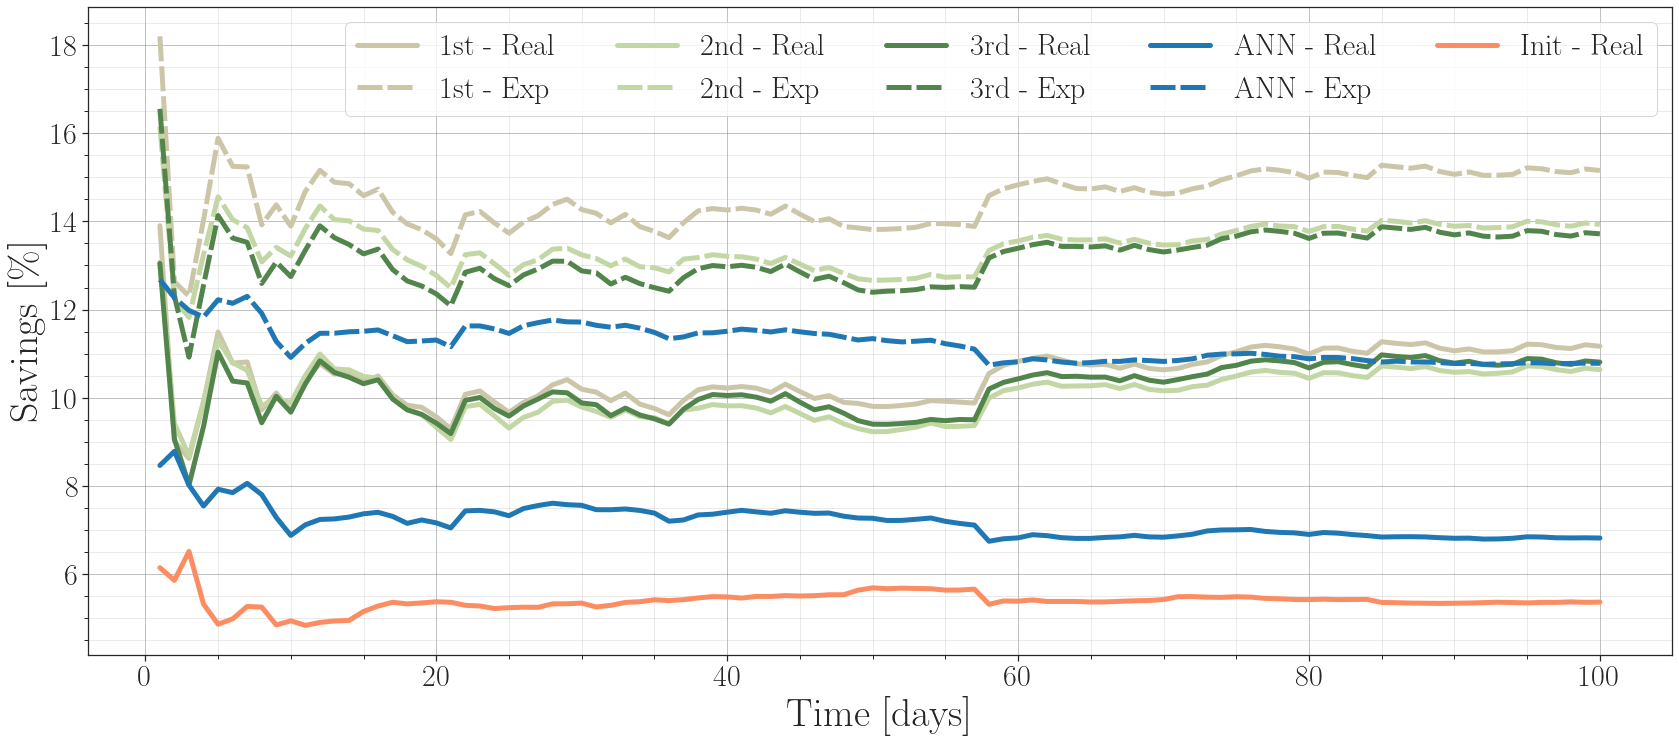

In [116]:
fig = plt.figure(figsize=(25,10))  
ax = fig.add_subplot(111)
days = range(1,101)
ax.plot(days,price_m1_02_save,label= r'$\textnormal{1st - Real}$',color=col_mod1_line,linewidth=linewidth)
ax.plot(days,price_m1_02_save_exp,label= r'$\textnormal{1st - Exp}$',color=col_mod1_line,linestyle=exp_line_style,linewidth=linewidth)

ax.plot(days,price_m2_02_save,label= r'$\textnormal{2nd - Real}$',color=col_mod2,linewidth=linewidth)
ax.plot(days,price_m2_02_save_exp,label= r'$\textnormal{2nd - Exp}$',color=col_mod2,linestyle=exp_line_style,linewidth=linewidth)

ax.plot(days,price_m3_02_save,label= r'$\textnormal{3rd - Real}$',color=col_mod3,linewidth=linewidth)
ax.plot(days,price_m3_02_save_exp,label= r'$\textnormal{3rd - Exp}$',color=col_mod3,linestyle=exp_line_style,linewidth=linewidth)

ax.plot(days,price_ann_save,label= r'$\textnormal{ANN - Real}$',color=sns.color_palette("Paired")[1],linewidth=linewidth)
ax.plot(days,price_ann_save_exp,label= r'$\textnormal{ANN - Exp}$',color=sns.color_palette("Paired")[1],linestyle=exp_line_style,linewidth=linewidth)

ax.plot(days,price_init_save,label= r'$\textnormal{Init - Real}$',color=sns.color_palette("Set2")[1],linewidth=linewidth)

#ax.plot(price_idle,label= r'$\textsc{idle}$',color=col_idle,alpha = 0.5,linewidth=linewidth)

#ax.plot(rel_dap_m1,label= r'$\textnormal{Model 1 - Dap}$',color='black')
#ax.plot(rel_dap_m1_exp,label= r'$\textnormal{Model 1 - Dap}$',color='black',alpha = 0.5)
setupAxis(ax,ncol_legend=5)

y_ticks = ax.get_yticks()
[str(int(100*y_ticks[i])) for i in range(len(y_ticks))]
ax.set_yticklabels(['$'+ str(int(100*y_ticks[i]))+'$' for i in range(len(y_ticks))])

ax.set_ylabel(r'$\textnormal{Savings [\%]} $')
ax.set_xlabel(r'$\textnormal{Time [days]} $')

plt.subplots_adjust(hspace = 0.,bottom=0.05, top =0.95,left = 0.07, right = 0.95,)
plt.savefig(FIGS + '/ann/rk_longterm_save_acc_ann.pdf',format='pdf')


# 2019 model 1 vs ann

In [117]:
model_sys = 'm1'
slope = 0.2
n_s = 6
filename_ann_2019 = '../results/sim_history/rk_ann_history_(2019-01-01 12:00:00)_(100_days)' + '_(price_slope_' + str(slope) +  ')_(regime_slope_' + str(slope) +  ')_(seed_1235)_(n_s_' + str(n_s) + ')_(sys_model_' + 'm1' + ')_(sys_true_m3).npy'
histories_ann_2019 = np.load(filename_ann_2019,allow_pickle=True).item()

model_sys = 'm1'
slope = 0.2
filename_m1_2019 = '../results/sim_history/rk_history_(2019-01-01 12:00:00)_(100_days)' + '_(price_slope_' + str(slope) +  ')_(regime_slope_' + str(slope) +  ')_(seed_1235)_(n_s_' + str(n_s) + ')_(sys_model_' + 'm1' + ')_(sys_true_m3).npy'
histories_m1_2019 = np.load(filename_m1_2019,allow_pickle=True).item()

filename_m1_2019_reuse = '../results/sim_history/rk_history_reuse(2019-01-01 12:00:00)_(100_days)' + '_(price_slope_' + str(slope) +  ')_(regime_slope_' + str(slope) +  ')_(seed_1235)_(n_s_' + str(n_s) + ')_(sys_model_' + 'm1' + ')_(sys_true_m4).npy'
histories_m1_2019_reuse = np.load(filename_m1_2019_reuse,allow_pickle=True).item()

price_idle_2019 = np.array([histories_m1_2019['price_true_idle'][day][-1] for day in range(100)])
price_idle_exp_2019 = np.array([histories_m1_2019_reuse['price_true_idle'][day][-1] for day in range(100)])



In [118]:
price_idle_2019 = np.array([histories_m1_2019['price_true_idle'][day][-1] for day in range(100)])
# Use reuse since this does not have diffusion = Expected
price_idle_exp_2019 = np.array([histories_m1_2019_reuse['price_true_idle'][day][-1] for day in range(100)])


price_ann_2019 = np.array([histories_ann_2019['price_true'][day][-1] for day in range(100)])
price_ann_exp_2019 = np.array([histories_ann_2019['price_model_rk'][day][-1] for day in range(100)])
price_m1_2019 = np.array([histories_m1_2019['price_true'][day][-1] for day in range(100)])
price_m1_2019_exp = np.array([histories_m1_2019['price_model_rk'][day][-1] for day in range(100)])
price_m1_2019_init = np.array([histories_m1_2019['price_true_init_switch'][day][-1] for day in range(100)])

price_ann_save_2019 = (price_idle_2019 - price_ann_2019)/price_idle_2019
price_ann_save_exp_2019 = (price_idle_exp_2019 - price_ann_exp_2019)/price_idle_exp_2019
price_m1_2019_save = (price_idle_2019 - price_m1_2019)/price_idle_2019
price_m1_2019_save_exp = (price_idle_exp_2019 - price_m1_2019_exp)/price_idle_exp_2019

price_m1_2019_init_save = (price_idle_2019 - price_m1_2019_init)/price_idle_2019


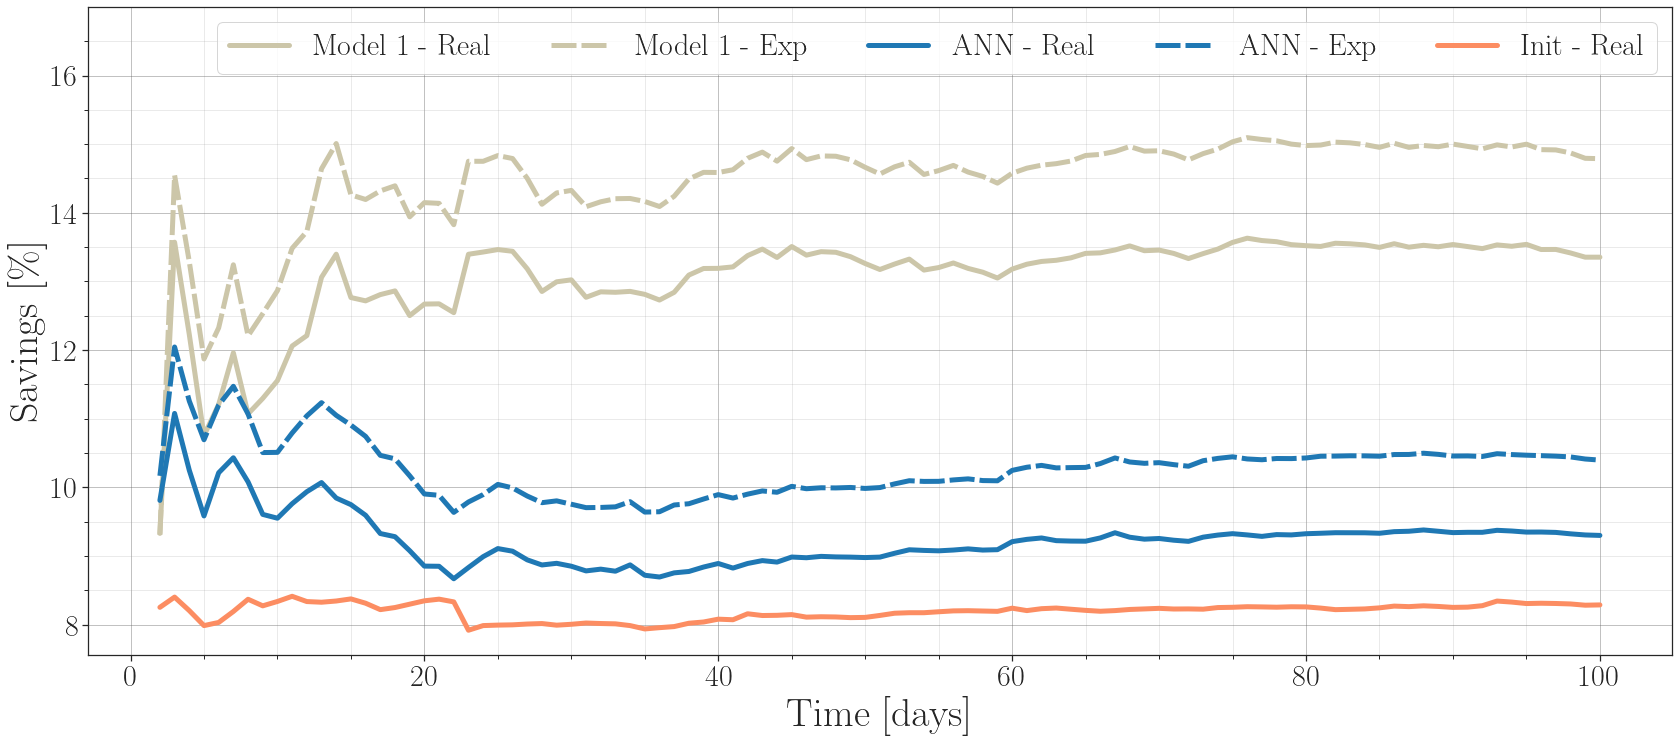

In [119]:
fig = plt.figure(figsize=(25,10))  
ax = fig.add_subplot(111)
days = range(2,101)
ax.plot(days,price_m1_2019_save[1:],label= r'$\textnormal{Model 1 - Real}$',color=col_mod1_line,linewidth=linewidth)
ax.plot(days,price_m1_2019_save_exp[1:],label= r'$\textnormal{Model 1 - Exp}$',color=col_mod1_line,linestyle=exp_line_style,linewidth=linewidth)

ax.plot(days,price_ann_save_2019[1:],label= r'$\textnormal{ANN - Real}$',color=sns.color_palette("Paired")[1],linewidth=linewidth)
ax.plot(days,price_ann_save_exp_2019[1:],label= r'$\textnormal{ANN - Exp}$',color=sns.color_palette("Paired")[1],linestyle=exp_line_style,linewidth=linewidth)

ax.plot(days,price_m1_2019_init_save[1:],label= r'$\textnormal{Init - Real}$',color=sns.color_palette("Set2")[1],linewidth=linewidth)
#ax.plot(price_idle,label= r'$\textsc{idle}$',color=col_idle,alpha = 0.5,linewidth=linewidth)

#ax.plot(rel_dap_m1,label= r'$\textnormal{Model 1 - Dap}$',color='black')
#ax.plot(rel_dap_m1_exp,label= r'$\textnormal{Model 1 - Dap}$',color='black',alpha = 0.5)
setupAxis(ax,ncol_legend=5)

ax.set_ylim(ymax = 0.17)
y_ticks = ax.get_yticks()
[str(int(100*y_ticks[i])) for i in range(len(y_ticks))]
ax.set_yticklabels(['$'+ str(int(100*y_ticks[i]))+'$' for i in range(len(y_ticks))])

ax.set_ylabel(r'$\textnormal{Savings [\%]} $')
ax.set_xlabel(r'$\textnormal{Time [days]} $')
#ax.legend(prop={'size': 30/scale},ncol=ncol_legend)
plt.subplots_adjust(hspace = 0.,bottom=0.05, top =0.95,left = 0.07, right = 0.95,)
plt.savefig(FIGS + '/ann/rk_longterm_save_acc_ann_2019.pdf',format='pdf')


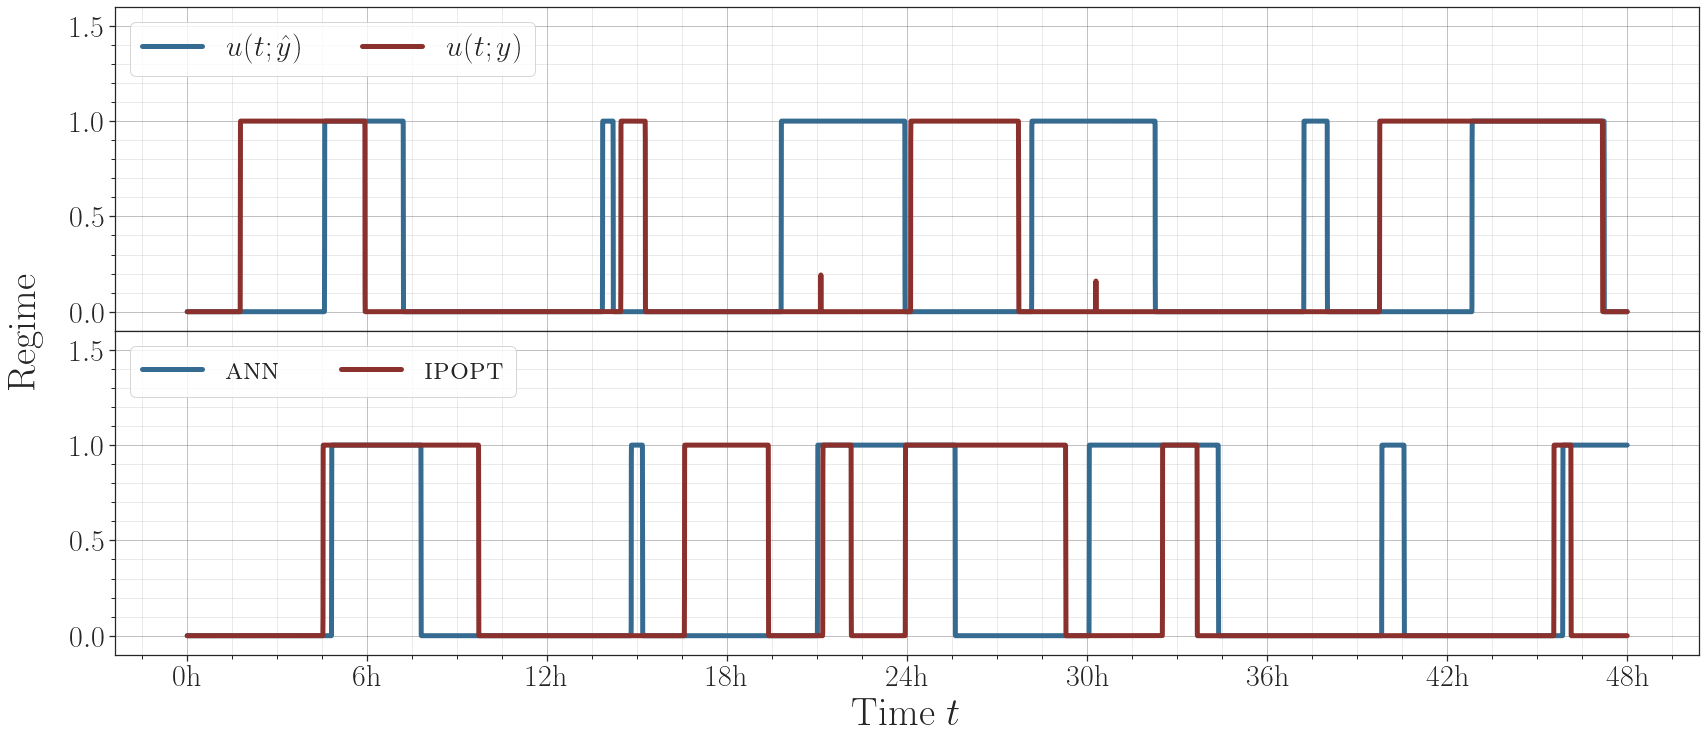

In [70]:
day = 96
fig = plt.figure(figsize=(25,10))  
ax = fig.add_subplot(211)
T = np.linspace(0,2*24*60,10000,)
linewidth_reg = 5

ax.plot(T,smooth_regime(T,histories_ann['SWITCHES_rk'][day]),label=r'$u(t;\hat y)$',color=blue[1],linewidth=linewidth_reg)
ax.plot(T,smooth_regime(T,histories_02['m1']['SWITCHES_rk'][day]),label=r'$u(t;y)$',color=red[1],linewidth=linewidth_reg)

setupAxis(ax)
ax.set_ylim(-0.1,1.6)
ax.legend(prop={'size': 30},ncol=2,loc = 'upper left')


ax.set_xticks(np.arange(0,2*25,6)*(60.))
ax.set_xticklabels(['' for _t in np.arange(0,2*25,6) * 60.])

ax1 = fig.add_subplot(212)
day = 20
T = np.linspace(0,2*24*60,10000,)

ax1.plot(T,smooth_regime(T,histories_ann_2019['SWITCHES_rk'][day]),label=r'$\textnormal{\textsc{ann}}$',color=blue[1],linewidth=linewidth_reg)
ax1.plot(T,smooth_regime(T,histories_m1_2019['SWITCHES_rk'][day]),label=r'$\textnormal{\textsc{ipopt}}$',color=red[1],linewidth=linewidth_reg)
setupAxis(ax1)
ax1.set_ylim(-0.1,1.6)
ax1.legend(prop={'size': 30},ncol=2,loc = 'upper left')

ax.set_ylabel(r'')
ax1.set_ylabel(r'')
ax1.set_xlabel(r'$\textnormal{Time } t$')

plt.subplots_adjust(left = 0.07, right = 0.95, hspace=0.)

fig.text(0.01, 0.5, r'$\textnormal{Regime}$', va='center', rotation='vertical',fontsize = 40)

ax1.set_xticks(np.arange(0,2*25,6)*(60.))
ax1.set_xticklabels(['$'+str(int(_t/60.)) + r' \textnormal{h}$' for _t in np.arange(0,2*25,6) * 60.])

plt.subplots_adjust(hspace = 0.,bottom=0.05, top =0.95,left = 0.07, right = 0.95,)
plt.savefig(FIGS + '/ann/rk_longterm_ann_pred_comp.pdf',format='pdf')
